In [1]:
import sys
print(sys.version)

3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]


In [2]:
# Light GBM 모델 설치
!pip install lightgbm

In [3]:
import pickle
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy import stats
import tensorflow as tf
from datetime import date
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from datetime import datetime, timedelta
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
%matplotlib inline

In [4]:
# 한글 폰트 적용
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'Malgun Gothic'

In [5]:
# 5개 모델 관련 import
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor, plot_importance
from tensorflow.keras import datasets, layers, models
from sklearn.linear_model import LinearRegression
import logging

In [12]:
# 원본 프레임 불러오기
import pickle
df_ = pd.read_pickle('data/merged_dataframe.pickle')

# 1. Linear Regression Model

In [13]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 544500 entries, 0 to 544499
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   역명            544500 non-null  object        
 1   date          544500 non-null  datetime64[ns]
 2   시간            544500 non-null  object        
 3   하차            544500 non-null  int64         
 4   승차            544500 non-null  int64         
 5   요일            544500 non-null  object        
 6   공휴일           544500 non-null  int64         
 7   주말제외공휴일       544500 non-null  int64         
 8   corona_stage  544500 non-null  int64         
 9   8주평균하차수       544500 non-null  float64       
 10  4주평균하차수       544500 non-null  float64       
 11  2주평균하차수       544500 non-null  float64       
 12  2주평균승차수       544500 non-null  float64       
 13  4주평균승차수       544500 non-null  float64       
 14  8주평균승차수       544500 non-null  float64       
 15  행정구역_확진자      544

In [14]:
df_.drop(['검색트랜드'], axis=1, inplace=True)

### 전처리

In [89]:
# Nan 채우기 : imputer - median
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
df_['검색트랜드(한양)'] = imputer.fit_transform(df_[['검색트랜드(한양)']])
df_['지+버승차'] = imputer.fit_transform(df_[['지+버승차']])
df_['지+버하차'] = imputer.fit_transform(df_[['지+버하차']])

##1. 전체로 예측

In [101]:
data = df_.copy()

In [102]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S', errors='raise')
data['date_month'] = data['date'].dt.month

In [92]:
def total_linear_regression(data,cols,month): #데이터, 사용될 columns, 예측될 월
    test =  data[data['date_month'] == month]
    train = data[data['date_month'] != month]
    train, test = train[cols],test[cols]
    y_train, X_train = train['하차'] , train.drop('하차',axis=1)
    y_test, X_test = test['하차'] , test.drop('하차',axis=1)

    lin_reg = LinearRegression()
    X_train_ready = df_pipeline.fit_transform(X_train)
    lin_reg.fit(X_train_ready, y_train)
    X_test_ready = df_pipeline.transform(X_test)

    train_score = round(lin_reg.score(X_train_ready,y_train),4)
    test_score = round(lin_reg.score(X_test_ready,y_test),4)
    print('train: {}'.format(train_score))
    print('test: {}'.format(test_score))

In [93]:
data.columns

Index(['역명', 'date', '시간', '하차', '승차', '요일', '공휴일', '주말제외공휴일', 'corona_stage',
       '8주평균하차수', '4주평균하차수', '2주평균하차수', '2주평균승차수', '4주평균승차수', '8주평균승차수',
       '행정구역_확진자', '전국_확진자', '검색트랜드(한양)', '기온(°C)', '강수량(mm)', '풍속(m/s)',
       '습도(%)', '지+버승차', '지+버하차', 'date_month'],
      dtype='object')

In [95]:
numeric_columns = ['공휴일','corona_stage','8주평균하차수','전국_확진자','기온(°C)', '습도(%)']
cgr_columns = ['요일','시간']
numeric_pipeline = Pipeline([
                             ('imputer', SimpleImputer()),
                             ('scaler', StandardScaler()
                             )])
cgr_pipeline = Pipeline([
                         ('onehot', OneHotEncoder())
                         ])
df_pipeline = ColumnTransformer([
                                 ('num_pipeline', numeric_pipeline, numeric_columns),
                                 ('cgr_pipeline', cgr_pipeline, cgr_columns)
])
cols = numeric_columns + cgr_columns + ['하차']
print('사용된 feature : 전체 feature')
total_linear_regression(data,cols,5)

사용된 feature : 전체 feature
train: 0.9423
test: 0.89


In [96]:
## feature importance
month = 5
test =  data[data['date_month'] == month]
train = data[data['date_month'] != month]
train, test = train[cols],test[cols]
y_train, X_train = train['하차'] , train.drop('하차',axis=1)
y_test, X_test = test['하차'] , test.drop('하차',axis=1)

lin_reg = LinearRegression()
X_train_ready = df_pipeline.fit_transform(X_train)
lin_reg.fit(X_train_ready, y_train)
X_test_ready = df_pipeline.transform(X_test)

train_score = round(lin_reg.score(X_train_ready,y_train),4)
test_score = round(lin_reg.score(X_test_ready,y_test),4)
print('train: {}'.format(train_score))
print('test: {}'.format(test_score))

train: 0.9423
test: 0.89


In [97]:
len(lin_reg.coef_), len(cols),len(numeric_columns)
a = list(lin_reg.coef_)
b = [abs(i) for i in lin_reg.coef_]
importance = numeric_columns + ['요일{}'.format(i) for i in range(7)] + ['시간{}'.format(i) for i in range(20)]
dic = {'중요도':b,'칼럼':importance}
dic = pd.DataFrame(dic)

In [98]:
dic.sort_values(by=['중요도'],ascending=False)

,중요도,칼럼
2,1070.000588,8주평균하차수
11,161.516986,요일5
10,150.748904,요일4
0,122.107764,공휴일
16,120.820294,시간3
7,87.821548,요일1
15,87.313414,시간2
12,72.794968,요일6
3,69.100937,전국_확진자
17,68.293267,시간4


In [42]:
print('사용된 feature: 8주평균하차수')
numeric_columns = ['8주평균하차수']
df_pipeline = ColumnTransformer([
                                 ('num_pipeline', numeric_pipeline, numeric_columns)
])
cols = numeric_columns + ['하차']
total_linear_regression(data,cols,5)

사용된 feature: 8주평균하차수
train: 0.9348
test: 0.8785


##2. 역마다 예측

In [107]:
# 역 라벨링
encoder=LabelEncoder()
encoder.fit(data['역명'])
sample_label = encoder.transform(data['역명'])
Label_ref = pd.DataFrame(encoder.classes_,index=list(set(sample_label)),columns=['역명'])
data['역명_label'] = sample_label

In [108]:
def station_linear_regression(data,cols,days): #데이터, 사용될 column, 예측될 월의 요일수
    score_train, score_test = [],[]
    num = len(set(data['역명_label']))
    for i in tqdm(range(num)):
        prac = data[data['역명_label']==i]  
        prac = prac[cols]
        y = prac['하차']
        X = prac.drop('하차',axis=1)

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=days*20,shuffle=False)
        X_train_ready = df_pipeline.fit_transform(X_train)
        lin_reg = LinearRegression()
        lin_reg.fit(X_train_ready, y_train)
        score_train.append(lin_reg.score(X_train_ready, y_train))
        X_test_ready = df_pipeline.transform(X_test)
        score_test.append(lin_reg.score(X_test_ready, y_test))
    train_score = round(np.mean(score_train),4)
    test_score = round(np.mean(score_test),4)
    print('train: {}'.format(train_score))
    print('test: {}'.format(test_score))

In [109]:
print('사용된 feature:전체 feature')
numeric_columns = ['공휴일','corona_stage','8주평균하차수','전국_확진자','기온(°C)', '습도(%)']
cgr_columns = ['요일','시간']
numeric_pipeline = Pipeline([
                             ('scaler', StandardScaler()
                             )])
cgr_pipeline = Pipeline([
                         ('onehot', OneHotEncoder())
                         ])
df_pipeline = ColumnTransformer([
                                 ('num_pipeline', numeric_pipeline, numeric_columns),
                                 ('cgr_pipeline', cgr_pipeline, cgr_columns)
])
cols = numeric_columns + cgr_columns + ['하차']
station_linear_regression(data,cols,31)


  1%|▋                                                                                 | 2/225 [00:00<00:11, 19.27it/s]


사용된 feature:전체 feature


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:04<00:00, 47.87it/s]

train: 0.9334
test: 0.8447


In [ ]:
print('사용된 feature: 8주평균하차수')
numeric_columns = ['8주평균하차수']
numeric_pipeline = Pipeline([
                             ('scaler', StandardScaler()
                             )])
df_pipeline = ColumnTransformer([
                                 ('num_pipeline', numeric_pipeline, numeric_columns)
])
cols = numeric_columns + ['하차']
station_linear_regression(data,cols,31)

사용된 feature: 8주평균하차수



train: 0.9037
test: 0.8733


# 2. RandomForest Regression Model

In [20]:
df = df_.copy()

### 라벨링

In [21]:
# 1. 요일 라벨링
encoder=LabelEncoder()
encoder.fit(df['요일'])

LabelEncoder()

In [22]:
encoder.classes_

array(['금요일', '목요일', '수요일', '월요일', '일요일', '토요일', '화요일'], dtype=object)

In [23]:
sample_label=encoder.transform(df['요일'])
Label_ref=pd.DataFrame(encoder.classes_,index=list(set(sample_label)),columns=['요일'])
Label_ref.head

<bound method NDFrame.head of     요일
0  금요일
1  목요일
2  수요일
3  월요일
4  일요일
5  토요일
6  화요일>

In [24]:
df['요일_label'] = sample_label

In [25]:
# 2. 역 라벨링
encoder=LabelEncoder()
encoder.fit(df['역명'])
encoder.classes_

array(['가락시장', '가산디지털단지', '강남', '강남구청', '강동', '강동구청', '강변(동서울터미널)', '개롱',
       '개화산', '거여', '건대입구', '경복궁(정부서울청사)', '경찰병원', '고덕', '고려대(종암)',
       '고속터미널', '공덕', '공릉(서울과학기술대)', '광나루(장신대)', '광명사거리', '광화문(세종문화회관)',
       '광흥창(서강)', '교대(법원.검찰청)', '구로디지털단지', '구산', '구의(광진구청)', '구파발',
       '군자(능동)', '굽은다리(강동구민회관앞)', '금호', '길동', '길음', '김포공항', '까치산', '낙성대',
       '남구로', '남부터미널(예술의전당)', '남성', '남태령', '내방', '노원', '녹번', '녹사평(용산구청)',
       '논현', '답십리', '당고개', '당산', '대림(구로구청)', '대청', '대치', '대흥(서강대앞)', '도곡',
       '도림천', '도봉산', '독립문', '독바위', '돌곶이', '동대문', '동대문역사문화공원', '동대입구',
       '동묘앞', '동작(현충원)', '둔촌동', '디지털미디어시티', '뚝섬', '뚝섬유원지', '마곡', '마들',
       '마장', '마천', '마포', '마포구청', '망원', '매봉', '먹골', '면목', '명동', '명일', '목동',
       '몽촌토성(평화의문)', '무악재', '문래', '문정', '미아(서울사이버대학)', '미아사거리', '반포',
       '발산', '방배', '방이', '방화', '버티고개', '보라매', '보문', '복정', '봉천',
       '봉화산(서울의료원)', '불광', '사가정', '사당', '삼각지', '삼성(무역센터)', '상계', '상도',
       '상봉(시외버스터미널)', '상수', '상왕십리', '상월곡(한국과학기술연구원)', '상일동', '새절(신사)',
  

In [26]:
sample_label = encoder.transform(df['역명'])
Label_ref = pd.DataFrame(encoder.classes_,index=list(set(sample_label)),columns=['역명'])
Label_ref.head

<bound method NDFrame.head of               역명
0           가락시장
1        가산디지털단지
2             강남
3           강남구청
4             강동
..           ...
220           홍제
221           화곡
222  화랑대(서울여대입구)
223    회현(남대문시장)
224        효창공원앞

[225 rows x 1 columns]>

In [27]:
df['역명_label'] = sample_label

### train (2~4월) / test (5월) 분리

In [28]:
train = df[df['date'].dt.month != 5]
test = df[df['date'].dt.month == 5]
train.reset_index(drop = True, inplace = True)
test.reset_index(drop = True, inplace = True)

In [ ]:
# 저장해서 빼놓기
# train.to_pickle('train_2.pkl')
# test.to_pickle('test_2.pkl')

In [43]:
train = pd.read_pickle('train_2.pkl')
test = pd.read_pickle('test_2.pkl')

In [ ]:
# train set, validation set 구별을 위한 kfold 지정
# kfold = KFold(n_splits=5, random_state=42, shuffle=True)

In [44]:
test.set_index('date', inplace=True)
train.set_index('date', inplace=True)

In [45]:
train.shape[0], test.shape[0]

(405000, 139500)

In [46]:
train_x = train.drop(['하차'],axis=1)
train_y = train[['하차']]
test_x = test.drop(['하차'],axis=1)
test_y = test[['하차']]

In [47]:
# 전체 피쳐 확인
train_x.columns

Index(['역명', '역명_label', '시간', '요일', '요일_label', '공휴일', '주말제외공휴일',
       'corona_stage', '8주평균하차수', '4주평균하차수', '2주평균하차수', '2주평균승차수', '4주평균승차수',
       '8주평균승차수', '행정구역_확진자', '전국_확진자', '검색트랜드(한양)', '기온(°C)', '강수량(mm)',
       '습도(%)', '지+버승차', '지+버하차'],
      dtype='object')

In [48]:
(train_x.shape, train_y.shape), (test_x.shape, test_y.shape)

(((405000, 22), (405000, 1)), ((139500, 22), (139500, 1)))

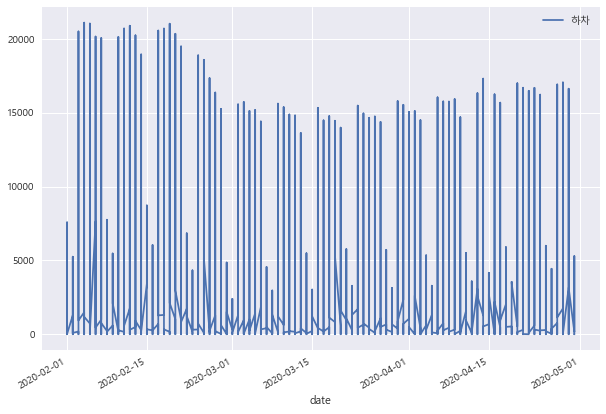

In [36]:
plt.rcParams["figure.figsize"] = (10,7)
train_y.plot()

In [38]:
# plt.rcParams["figure.figsize"] = (10,7)
# train_x.hist(bins=20)
# plt.show()

##1. 전체로 예측

In [39]:
# 비교군
train_x = train[['8주평균하차수']]
train_y = train[['하차']]
test_x = test[['8주평균하차수']]
test_y = test[['하차']]

In [40]:
scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
np.mean(train_x), np.std(train_x)

(-7.29841427348646e-18, 0.9999999999999999)

In [41]:
test_x = scaler.transform(test_x)
np.mean(test_x), np.std(test_x)

(-0.114619448135038, 0.828485281504183)

In [42]:
forest_base = RandomForestRegressor(n_estimators=100, max_depth=5, criterion='mse', random_state=42, n_jobs=-1)
forest_base.fit(train_x, train_y)
train_y_pred_base = forest_base.predict(train_x)
test_y_pred_base = forest_base.predict(test_x)

r2_train = r2_score(train_y, train_y_pred_base)
r2_test = r2_score(test_y, test_y_pred_base)
print('r2 - train:{}, test:{}'.format(r2_train, r2_test))

r2 - train:0.9360676651227746, test:0.8764025280757515


- 8주만 : train:0.9360676651227746, test:0.8764025280757515
- 4주만 : train:0.9442180151426625, test:0.886986483904546
- 2주만 : train:0.9394361865536506, test:0.8741618892576585

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


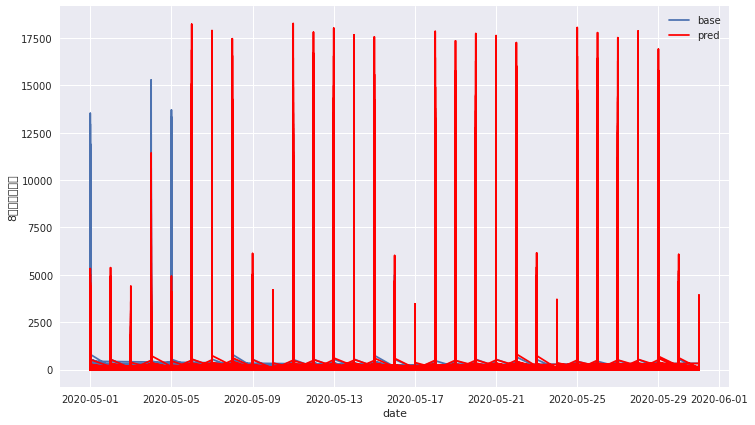

In [ ]:
plt.figure(figsize = (12, 7))
plt.plot(test.index, test_y_pred_base, test.index, test['하차'], 'r-')
plt.xlabel('date')
plt.ylabel('8주평균하차수')
plt.legend(labels = ('base', 'pred'))

### 1. 평균하차2주차 

In [ ]:
train_x = train_x.drop(['지+버승차', '지+버하차','2주평균승차수','8주평균승차수', '4주평균승차수', '8주평균하차수', '4주평균하차수', '주말제외공휴일','역명', '요일'], axis=1)
test_x = test_x.drop(['지+버승차', '지+버하차','2주평균승차수','8주평균승차수', '4주평균승차수', '8주평균하차수', '4주평균하차수', '주말제외공휴일','역명', '요일'], axis=1)

In [ ]:
train_x

,역명_label,시간,요일_label,공휴일,corona_stage,2주평균하차수,행정구역_확진자,전국_확진자,검색트랜드(한양),기온(°C),강수량(mm),습도(%)
date,,,,,,,,,,,,
2020-02-01,0,5,5,1,0,55.5,0,0.0,14.333194,-0.5,0.0,70
2020-02-01,0,6,5,1,0,222.0,0,0.0,14.333194,-0.5,0.0,69
2020-02-01,0,7,5,1,0,262.5,0,0.0,14.333194,-1.1,0.0,80
2020-02-01,0,8,5,1,0,451.5,0,0.0,14.333194,-0.8,0.0,79
2020-02-01,0,9,5,1,0,499.0,0,0.0,14.333194,0.1,0.0,72
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-30,224,20,1,1,2,277.0,0,67.0,21.441077,19.2,0.0,73
2020-04-30,224,21,1,1,2,263.5,0,67.0,21.441077,18.8,0.0,77
2020-04-30,224,22,1,1,2,207.0,0,67.0,21.441077,18.3,0.0,77


In [ ]:
scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
np.mean(train_x), np.std(train_x)

(-2.3509315207865045e-18, 1.0000000000000007)

In [ ]:
test_x = scaler.transform(test_x)
np.mean(test_x), np.std(test_x)

(0.17733998341875926, 1.3181603108425588)

In [ ]:
forest = RandomForestRegressor(n_estimators=100, max_depth=5, criterion='mse', random_state=42, n_jobs=-1)
forest.fit(train_x, train_y)
train_y_pred = forest.predict(train_x)
test_y_pred = forest.predict(test_x)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [ ]:
r2_train = r2_score(train_y, train_y_pred)
r2_test = r2_score(test_y, test_y_pred)
print('r2 - train:{}, test:{}'.format(r2_train, r2_test))

r2 - train:0.9464177458101464, test:0.8748421690481586


<2주차> train:0.9464177458101464, test:0.8748421690481586


In [ ]:
cols = ['역명_label','시간', '요일_label', '공휴일','corona_stage', '2주평균하차수', '행정구역_확진자', '전국_확진자', '검색트랜드(한양)', '기온(°C)', '강수량(mm)', '습도(%)']

In [ ]:
forest.feature_importances_
plt.figure(figsize=(15, 10))
plt.bar(cols, forest.feature_importances_)

In [ ]:
feature_importance = pd.DataFrame({'feature': cols, 'feature_importances': forest.feature_importances_})
feature_importance.sort_values(by='feature_importances', ascending = False).reset_index(drop=True)

,feature,feature_importances
0,2주평균하차수,9.907311e-01
1,전국_확진자,4.603594e-03
2,공휴일,4.507159e-03
3,기온(°C),1.411102e-04
4,행정구역_확진자,5.434641e-06
5,요일_label,4.055683e-06
6,습도(%),3.688646e-06
7,corona_stage,3.286559e-06
8,검색트랜드(한양),5.588276e-07
9,역명_label,0.000000e+00


### 2. 평균하차4주차 

In [ ]:
train_x = train_x.drop(['4주평균승차수','지+버승차', '지+버하차','2주평균승차수','8주평균승차수', '2주평균승차수', '8주평균하차수', '2주평균하차수', '주말제외공휴일', '역명', '요일', '역명_label', '요일_label', '습도(%)', '검색트랜드(한양)', '시간', '강수량(mm)'], axis=1)
test_x = test_x.drop(['4주평균승차수','지+버승차', '지+버하차','2주평균승차수','8주평균승차수', '2주평균승차수', '8주평균하차수', '2주평균하차수', '주말제외공휴일',  '역명', '요일', '역명_label', '요일_label', '습도(%)', '검색트랜드(한양)', '시간', '강수량(mm)'], axis=1)

In [ ]:
scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [ ]:
forest = RandomForestRegressor(n_estimators=100, max_depth=5, criterion='mse', random_state=42, n_jobs=-1)
forest.fit(train_x, train_y)
train_y_pred = forest.predict(train_x)
test_y_pred = forest.predict(test_x)

r2_train = r2_score(train_y, train_y_pred)
r2_test = r2_score(test_y, test_y_pred)
print('r2 - train:{}, test:{}'.format(r2_train, r2_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


r2 - train:0.9573544970888332, test:0.8942279758343897


<4주차> train:0.9573544970888332, test:0.8942279758343897

In [ ]:
cols = ['공휴일','corona_stage', '4주평균하차수', '행정구역_확진자', '전국_확진자', '기온(°C)']
forest.feature_importances_
feature_importance = pd.DataFrame({'feature': cols, 'feature_importances': forest.feature_importances_})
feature_importance.sort_values(by='feature_importances', ascending = False).reset_index(drop=True)

,feature,feature_importances
0,4주평균하차수,0.984596
1,전국_확진자,0.012110
2,공휴일,0.003054
3,기온(°C),0.000121
4,행정구역_확진자,0.000082
5,corona_stage,0.000037


### 3. 평균하차8주차 

In [49]:
train_x = train_x.drop(['지+버하차', '지+버승차', '8주평균승차수','4주평균승차수', '2주평균승차수', '4주평균하차수', '2주평균하차수', '주말제외공휴일', '역명', '요일'], axis=1)
test_x = test_x.drop(['지+버하차', '지+버승차', '8주평균승차수','4주평균승차수', '2주평균승차수', '4주평균하차수', '2주평균하차수', '주말제외공휴일', '역명', '요일'], axis=1)

In [50]:
train_x.columns

Index(['역명_label', '시간', '요일_label', '공휴일', 'corona_stage', '8주평균하차수',
       '행정구역_확진자', '전국_확진자', '검색트랜드(한양)', '기온(°C)', '강수량(mm)', '습도(%)'],
      dtype='object')

In [51]:
scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [52]:
forest = RandomForestRegressor(n_estimators=100, max_depth=5, criterion='mse', random_state=42, n_jobs=-1)
forest.fit(train_x, train_y)
train_y_pred = forest.predict(train_x)
test_y_pred = forest.predict(test_x)

r2_train = r2_score(train_y, train_y_pred)
r2_test = r2_score(test_y, test_y_pred)
print('r2 - train:{}, test:{}'.format(r2_train, r2_test))

r2 - train:0.9504320994052285, test:0.8901848973669296


<8주차> train:0.9504320994052285, test:0.8901848973669296

In [53]:
cols = ['역명_label', '시간', '요일_label', '공휴일', 'corona_stage', '8주평균하차수',
       '행정구역_확진자', '전국_확진자', '검색트랜드(한양)', '기온(°C)', '강수량(mm)', '습도(%)']
forest.feature_importances_
feature_importance = pd.DataFrame({'feature': cols, 'feature_importances': forest.feature_importances_})
feature_importance.sort_values(by='feature_importances', ascending = False).reset_index(drop=True)

,feature,feature_importances
0,8주평균하차수,9.835655e-01
1,전국_확진자,1.205496e-02
2,공휴일,4.212800e-03
3,요일_label,6.517676e-05
4,기온(°C),3.994023e-05
5,corona_stage,3.414539e-05
6,역명_label,2.126999e-05
7,시간,6.220808e-06
8,검색트랜드(한양),3.139308e-08
9,행정구역_확진자,0.000000e+00


##2. 역마다 예측

In [58]:
data = pd.read_pickle('final_dataframe_2.pickle')

In [59]:
data.columns

Index(['역명', '역명_label', 'date', '시간', '하차', '요일', '요일_label', '공휴일',
       '주말제외공휴일', 'corona_stage', '8주평균하차수', '4주평균하차수', '2주평균하차수', '2주평균승차수',
       '4주평균승차수', '8주평균승차수', '행정구역_확진자', '전국_확진자', '검색트랜드(한양)', '기온(°C)',
       '강수량(mm)', '습도(%)', '지+버승차', '지+버하차'],
      dtype='object')

In [62]:
score_train = []
score_test = []
feature_importance_li = []
for i in tqdm(range(225)):
    prac = data[data['역명_label']==i]
    prac = prac[['하차', '역명_label', '시간', '요일_label', '공휴일', 'corona_stage', '8주평균하차수',
       '행정구역_확진자', '전국_확진자', '검색트랜드(한양)', '기온(°C)', '강수량(mm)', '습도(%)']]
    y = prac['하차']
    X = prac.drop('하차', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,shuffle=False)
  
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
  
    forest = RandomForestRegressor(n_estimators=100, max_depth=5, criterion='mse', random_state=42, n_jobs=-1)
    forest.fit(X_train, y_train)
    score_train.append(forest.score(X_train, y_train))
    score_test.append(forest.score(X_test, y_test))
    feature_importance_li.append(forest.feature_importances_)

100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [01:55<00:00,  1.95it/s]


In [ ]:
# 비교분 8주차
print('8주차 - train : {}, test : {}'.format(sum(score_train)/len(score_train), sum(score_test)/len(score_test)))

8주차 - train : 0.9269435646938674, test : 0.8258573196078205


In [61]:
# 비교분 4주차
print('4주차 - train : {}, test : {}'.format(sum(score_train)/len(score_train), sum(score_test)/len(score_test)))

4주차 - train : 0.9309166771500412, test : 0.8675591914586679


In [57]:
# 비교분 2주차
print('2주차 - train : {}, test : {}'.format(sum(score_train)/len(score_train), sum(score_test)/len(score_test)))

2주차 - train : 0.9270085583108836, test : 0.858576049473815


In [ ]:
# 전체 Feature
print('2주차 - train : {}, test : {}'.format(sum(score_train)/len(score_train), sum(score_test)/len(score_test)))

2주차 - train : 0.9501484790938334, test : 0.7588230119533205


In [ ]:
# 전체 Feature
print('4주차 - train : {}, test : {}'.format(sum(score_train)/len(score_train), sum(score_test)/len(score_test)))

4주차 - train : 0.9610620956053645, test : 0.7595096307083453


In [63]:
# 전체 Feature
print('8주차 - train : {}, test : {}'.format(sum(score_train)/len(score_train), sum(score_test)/len(score_test)))

8주차 - train : 0.9634902909540503, test : 0.777578176595741


#3. Light Gradient Boosting Model (LGBM)

In [64]:
train = pd.read_pickle('train_2.pkl')
test = pd.read_pickle('test_2.pkl')

In [65]:
train.columns

Index(['역명', '역명_label', 'date', '시간', '하차', '요일', '요일_label', '공휴일',
       '주말제외공휴일', 'corona_stage', '8주평균하차수', '4주평균하차수', '2주평균하차수', '2주평균승차수',
       '4주평균승차수', '8주평균승차수', '행정구역_확진자', '전국_확진자', '검색트랜드(한양)', '기온(°C)',
       '강수량(mm)', '습도(%)', '지+버승차', '지+버하차'],
      dtype='object')

In [66]:
test.set_index('date', inplace=True)
train.set_index('date', inplace=True)

In [67]:
train_x = train.drop(['하차'], axis=1)
train_y = train[['하차']]
test_x = test.drop(['하차'], axis=1)
test_y = test[['하차']]

##1. 전체로 예측

In [68]:
# 비교군
train_x = train_x[['4주평균하차수']] 
test_x = test_x[['4주평균하차수']]                   

In [ ]:
# 전체 Feature
train_x = train_x[['공휴일', 'corona_stage', '8주평균하차수', '행정구역_확진자', '전국_확진자', '기온(°C)']]
test_x = test_x[['공휴일', 'corona_stage', '8주평균하차수', '행정구역_확진자', '전국_확진자', '기온(°C)']]

In [69]:
sscaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [70]:
train_ds = lgb.Dataset(train_x, label = train_y)
test_ds = lgb.Dataset(test_x, label = test_y)

In [71]:
params = {'num_leaves': 300,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 1,
         "verbosity": -1}

In [72]:
# model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)
model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.991625
[200]	valid_0's auc: 0.991625
[300]	valid_0's auc: 0.991625
[400]	valid_0's auc: 0.991625
[500]	valid_0's auc: 0.991625
[600]	valid_0's auc: 0.991625
[700]	valid_0's auc: 0.991625
[800]	valid_0's auc: 0.991625
[900]	valid_0's auc: 0.991625
[1000]	valid_0's auc: 0.991625


In [73]:
predict_train = model.predict(train_x)
predict_test = model.predict(test_x)

In [74]:
r2 = r2_score(test_y, predict_test)
print('R2 score : ', r2)

R2 score :  0.8821154750334486


- 전체 - 전체로 예측 : 0.8441 (8주)
- 전체 - 전체로 예측 : 0.8680 (4주)
- 전체 - 전체로 예측 : 0.8313 (2주)
- 한 Feature - 전체로 예측 : 0.8674 (2주)
- 한 Feature - 전체로 예측 : 0.8821 (4주)
- 한 Feature - 전체로 예측 : 0.8718 (8주)


In [ ]:
final_result = pd.concat([test_y.reset_index(drop=True), pd.DataFrame(predict_test)], axis = 1)

In [ ]:
final_result.columns = ['label','predict']

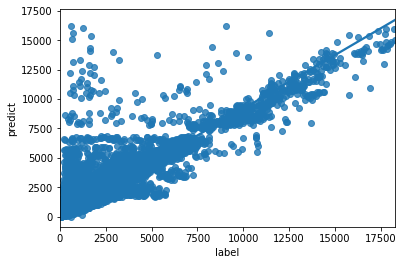

In [ ]:
sns.regplot(x = 'label', y = 'predict', data = final_result)

##2. 역마다 예측

In [80]:
data = pd.read_pickle('final_dataframe_2.pickle')

In [81]:
params = {'num_leaves': 300,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 1,
         "verbosity": -1}

In [82]:
score_list = []
feature_importance_li = []
for i in tqdm(range(225)):
    prac = data[data['역명_label']==i]
    prac = prac[['하차', '역명_label', '시간', '요일_label', '공휴일', 'corona_stage', '8주평균하차수',
       '행정구역_확진자', '전국_확진자', '검색트랜드(한양)', '기온(°C)', '강수량(mm)', '습도(%)']]
    # prac = prac[['하차', '8주평균하차수']]
    y = prac['하차']
    X = prac.drop('하차', axis=1)
  
    train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=42, shuffle=False)
    scaler = StandardScaler()
    scaler.fit(train_x)
    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)
  
    train_ds = lgb.Dataset(train_x, label = train_y)
    test_ds = lgb.Dataset(test_x, label = test_y)
  
    model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100)
    predict_train = model.predict(train_x)
    predict_test = model.predict(test_x)
    score_list.append(r2_score(test_y, predict_test))


  0%|                                                                                          | 0/225 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



  0%|▎                                                                                 | 1/225 [00:01<03:53,  1.04s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



  1%|▋                                                                                 | 2/225 [00:02<03:58,  1.07s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.98525
[200]	valid_0's auc: 0.986312
[300]	valid_0's auc: 0.987956
[400]	valid_0's auc: 0.988752
[500]	valid_0's auc: 0.98907
[600]	valid_0's auc: 0.989283
[700]	valid_0's auc: 0.992254
[800]	valid_0's auc: 0.990768
[900]	valid_0's auc: 0.990238
[1000]	valid_0's auc: 0.989601



  1%|█                                                                                 | 3/225 [00:03<04:22,  1.18s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



  2%|█▍                                                                                | 4/225 [00:04<04:22,  1.19s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



  2%|█▊                                                                                | 5/225 [00:05<04:13,  1.15s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



  3%|██▏                                                                               | 6/225 [00:07<04:11,  1.15s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.992833
[200]	valid_0's auc: 0.994
[300]	valid_0's auc: 0.992167
[400]	valid_0's auc: 0.989833
[500]	valid_0's auc: 0.988833
[600]	valid_0's auc: 0.983333
[700]	valid_0's auc: 0.984667
[800]	valid_0's auc: 0.985333
[900]	valid_0's auc: 0.984667
[1000]	valid_0's auc: 0.984333



  3%|██▌                                                                               | 7/225 [00:08<03:59,  1.10s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



  4%|██▉                                                                               | 8/225 [00:09<04:20,  1.20s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.817881
[200]	valid_0's auc: 0.817881
[300]	valid_0's auc: 0.817881
[400]	valid_0's auc: 0.819536
[500]	valid_0's auc: 0.819536
[600]	valid_0's auc: 0.821192
[700]	valid_0's auc: 0.824503
[800]	valid_0's auc: 0.822848
[900]	valid_0's auc: 0.821192
[1000]	valid_0's auc: 0.816225



  4%|███▎                                                                              | 9/225 [00:10<04:13,  1.17s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



  4%|███▌                                                                             | 10/225 [00:11<04:11,  1.17s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



  5%|███▉                                                                             | 11/225 [00:12<03:59,  1.12s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



  5%|████▎                                                                            | 12/225 [00:13<03:46,  1.06s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



  6%|████▋                                                                            | 13/225 [00:14<03:54,  1.11s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



  6%|█████                                                                            | 14/225 [00:15<03:48,  1.08s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



  7%|█████▍                                                                           | 15/225 [00:16<03:35,  1.03s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



  7%|█████▊                                                                           | 16/225 [00:17<03:30,  1.01s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



  8%|██████                                                                           | 17/225 [00:18<03:30,  1.01s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.924544
[200]	valid_0's auc: 0.927032
[300]	valid_0's auc: 0.944444
[400]	valid_0's auc: 0.966003
[500]	valid_0's auc: 0.975954
[600]	valid_0's auc: 0.978441
[700]	valid_0's auc: 0.972637
[800]	valid_0's auc: 0.961028
[900]	valid_0's auc: 0.957711



  8%|██████▍                                                                          | 18/225 [00:19<03:30,  1.02s/it]

[1000]	valid_0's auc: 0.952736
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.973199
[200]	valid_0's auc: 0.974142
[300]	valid_0's auc: 0.976235
[400]	valid_0's auc: 0.976131
[500]	valid_0's auc: 0.975921
[600]	valid_0's auc: 0.978643
[700]	valid_0's auc: 0.977178
[800]	valid_0's auc: 0.974874
[900]	valid_0's auc: 0.974874
[1000]	valid_0's auc: 0.974874



  8%|██████▊                                                                          | 19/225 [00:21<03:50,  1.12s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



  9%|███████▏                                                                         | 20/225 [00:22<04:01,  1.18s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



  9%|███████▌                                                                         | 21/225 [00:23<03:47,  1.12s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.961093
[200]	valid_0's auc: 0.961093
[300]	valid_0's auc: 0.958609
[400]	valid_0's auc: 0.956954
[500]	valid_0's auc: 0.956126
[600]	valid_0's auc: 0.955298
[700]	valid_0's auc: 0.958609
[800]	valid_0's auc: 0.978477
[900]	valid_0's auc: 0.981788
[1000]	valid_0's auc: 0.986755



 10%|███████▉                                                                         | 22/225 [00:24<03:33,  1.05s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.972222
[200]	valid_0's auc: 0.970149
[300]	valid_0's auc: 0.96932
[400]	valid_0's auc: 0.958541
[500]	valid_0's auc: 0.954395
[600]	valid_0's auc: 0.95398
[700]	valid_0's auc: 0.94942
[800]	valid_0's auc: 0.946932
[900]	valid_0's auc: 0.950249
[1000]	valid_0's auc: 0.955224



 10%|████████▎                                                                        | 23/225 [00:25<03:23,  1.01s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.970882
[200]	valid_0's auc: 0.973378
[300]	valid_0's auc: 0.973378
[400]	valid_0's auc: 0.972546
[500]	valid_0's auc: 0.97109
[600]	valid_0's auc: 0.967554
[700]	valid_0's auc: 0.964226
[800]	valid_0's auc: 0.96797
[900]	valid_0's auc: 0.968386
[1000]	valid_0's auc: 0.969634



 11%|████████▋                                                                        | 24/225 [00:26<03:44,  1.12s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.953168
[200]	valid_0's auc: 0.949495
[300]	valid_0's auc: 0.95378
[400]	valid_0's auc: 0.969391
[500]	valid_0's auc: 0.990817
[600]	valid_0's auc: 0.993419
[700]	valid_0's auc: 0.986838
[800]	valid_0's auc: 0.983165
[900]	valid_0's auc: 0.979951
[1000]	valid_0's auc: 0.977655



 11%|█████████                                                                        | 25/225 [00:27<03:33,  1.07s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.987105
[200]	valid_0's auc: 0.989185
[300]	valid_0's auc: 0.989185
[400]	valid_0's auc: 0.995424
[500]	valid_0's auc: 0.996672
[600]	valid_0's auc: 0.995632
[700]	valid_0's auc: 0.995008
[800]	valid_0's auc: 0.99376
[900]	valid_0's auc: 0.994176
[1000]	valid_0's auc: 0.993344



 12%|█████████▎                                                                       | 26/225 [00:28<03:23,  1.02s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 12%|█████████▋                                                                       | 27/225 [00:29<03:18,  1.00s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 12%|██████████                                                                       | 28/225 [00:30<03:13,  1.02it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 13%|██████████▍                                                                      | 29/225 [00:31<03:11,  1.02it/s]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.989496
[200]	valid_0's auc: 0.990296
[300]	valid_0's auc: 0.989946
[400]	valid_0's auc: 0.989846
[500]	valid_0's auc: 0.989896
[600]	valid_0's auc: 0.990296
[700]	valid_0's auc: 0.988695
[800]	valid_0's auc: 0.989596
[900]	valid_0's auc: 0.989696
[1000]	valid_0's auc: 0.987695



 13%|██████████▊                                                                      | 30/225 [00:32<03:25,  1.05s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1


 14%|███████████▏                                                                     | 31/225 [00:33<03:22,  1.04s/it]


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.993178
[200]	valid_0's auc: 0.992905
[300]	valid_0's auc: 0.992905
[400]	valid_0's auc: 0.992905
[500]	valid_0's auc: 0.99232
[600]	valid_0's auc: 0.99158
[700]	valid_0's auc: 0.991346
[800]	valid_0's auc: 0.990566
[900]	valid_0's auc: 0.990254



 14%|███████████▌                                                                     | 32/225 [00:34<03:18,  1.03s/it]

[1000]	valid_0's auc: 0.988929
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 15%|███████████▉                                                                     | 33/225 [00:35<03:17,  1.03s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 15%|████████████▏                                                                    | 34/225 [00:36<03:11,  1.00s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.943999
[200]	valid_0's auc: 0.951166
[300]	valid_0's auc: 0.967187
[400]	valid_0's auc: 0.971402
[500]	valid_0's auc: 0.973932
[600]	valid_0's auc: 0.974143
[700]	valid_0's auc: 0.973581
[800]	valid_0's auc: 0.975548
[900]	valid_0's auc: 0.977656
[1000]	valid_0's auc: 0.97864



 16%|████████████▌                                                                    | 35/225 [00:37<03:27,  1.09s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.986755
[200]	valid_0's auc: 0.986755
[300]	valid_0's auc: 0.987583
[400]	valid_0's auc: 0.990894
[500]	valid_0's auc: 0.996689
[600]	valid_0's auc: 0.996689
[700]	valid_0's auc: 0.988411
[800]	valid_0's auc: 0.985099
[900]	valid_0's auc: 0.985099
[1000]	valid_0's auc: 0.983444



 16%|████████████▉                                                                    | 36/225 [00:38<03:19,  1.05s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.979833
[200]	valid_0's auc: 0.982333
[300]	valid_0's auc: 0.983333
[400]	valid_0's auc: 0.982833
[500]	valid_0's auc: 0.983667
[600]	valid_0's auc: 0.978667
[700]	valid_0's auc: 0.976667
[800]	valid_0's auc: 0.972
[900]	valid_0's auc: 0.97
[1000]	valid_0's auc: 0.966



 16%|█████████████▎                                                                   | 37/225 [00:39<03:16,  1.04s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 17%|█████████████▋                                                                   | 38/225 [00:40<03:19,  1.07s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.988992
[200]	valid_0's auc: 0.987395
[300]	valid_0's auc: 0.98958
[400]	valid_0's auc: 0.989916
[500]	valid_0's auc: 0.989076
[600]	valid_0's auc: 0.984874
[700]	valid_0's auc: 0.980672
[800]	valid_0's auc: 0.97916
[900]	valid_0's auc: 0.977143
[1000]	valid_0's auc: 0.975126



 17%|██████████████                                                                   | 39/225 [00:42<03:21,  1.08s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 18%|██████████████▍                                                                  | 40/225 [00:43<03:43,  1.21s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 18%|██████████████▊                                                                  | 41/225 [00:44<03:39,  1.20s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.975819
[200]	valid_0's auc: 0.972605
[300]	valid_0's auc: 0.972452
[400]	valid_0's auc: 0.972834
[500]	valid_0's auc: 0.979109
[600]	valid_0's auc: 0.983318
[700]	valid_0's auc: 0.98393
[800]	valid_0's auc: 0.984083
[900]	valid_0's auc: 0.983012
[1000]	valid_0's auc: 0.983012



 19%|███████████████                                                                  | 42/225 [00:45<03:34,  1.17s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1



 19%|███████████████▍                                                                 | 43/225 [00:47<03:31,  1.16s/it]

[1000]	valid_0's auc: 1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 20%|███████████████▊                                                                 | 44/225 [00:48<03:31,  1.17s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 20%|████████████████▏                                                                | 45/225 [00:49<03:42,  1.24s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.984272
[200]	valid_0's auc: 0.969371
[300]	valid_0's auc: 0.985927
[400]	valid_0's auc: 0.985099
[500]	valid_0's auc: 0.995033
[600]	valid_0's auc: 0.995033
[700]	valid_0's auc: 1
[800]	valid_0's auc: 0.998344
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 0.998344



 20%|████████████████▌                                                                | 46/225 [00:50<03:30,  1.18s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 21%|████████████████▉                                                                | 47/225 [00:51<03:23,  1.14s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 21%|█████████████████▎                                                               | 48/225 [00:52<03:13,  1.09s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.988196
[200]	valid_0's auc: 0.988196
[300]	valid_0's auc: 0.988196
[400]	valid_0's auc: 0.988898
[500]	valid_0's auc: 0.988196
[600]	valid_0's auc: 0.984401
[700]	valid_0's auc: 0.982996
[800]	valid_0's auc: 0.983277
[900]	valid_0's auc: 0.982434
[1000]	valid_0's auc: 0.982574



 22%|█████████████████▋                                                               | 49/225 [00:53<03:08,  1.07s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.982353
[200]	valid_0's auc: 0.981429
[300]	valid_0's auc: 0.98084
[400]	valid_0's auc: 0.980924
[500]	valid_0's auc: 0.979328
[600]	valid_0's auc: 0.981008
[700]	valid_0's auc: 0.981345
[800]	valid_0's auc: 0.979328
[900]	valid_0's auc: 0.978824
[1000]	valid_0's auc: 0.978487



 22%|██████████████████                                                               | 50/225 [00:55<03:23,  1.16s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 23%|██████████████████▎                                                              | 51/225 [00:56<03:14,  1.12s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 23%|██████████████████▋                                                              | 52/225 [00:57<03:08,  1.09s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.96995
[200]	valid_0's auc: 0.96995
[300]	valid_0's auc: 0.980106
[400]	valid_0's auc: 0.988453
[500]	valid_0's auc: 0.992766
[600]	valid_0's auc: 0.993879
[700]	valid_0's auc: 0.996105
[800]	valid_0's auc: 0.995826
[900]	valid_0's auc: 0.995548
[1000]	valid_0's auc: 0.99527



 24%|███████████████████                                                              | 53/225 [00:58<03:03,  1.07s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 24%|███████████████████▍                                                             | 54/225 [00:59<03:00,  1.06s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 24%|███████████████████▊                                                             | 55/225 [01:00<03:14,  1.15s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 25%|████████████████████▏                                                            | 56/225 [01:01<03:19,  1.18s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.963293
[200]	valid_0's auc: 0.971609
[300]	valid_0's auc: 0.980314
[400]	valid_0's auc: 0.982783
[500]	valid_0's auc: 0.983888
[600]	valid_0's auc: 0.982848
[700]	valid_0's auc: 0.985187
[800]	valid_0's auc: 0.984537
[900]	valid_0's auc: 0.980639
[1000]	valid_0's auc: 0.976741



 25%|████████████████████▌                                                            | 57/225 [01:02<03:18,  1.18s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 26%|████████████████████▉                                                            | 58/225 [01:03<03:10,  1.14s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 26%|█████████████████████▏                                                           | 59/225 [01:05<03:12,  1.16s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 27%|█████████████████████▌                                                           | 60/225 [01:06<03:31,  1.28s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1


 27%|█████████████████████▉                                                           | 61/225 [01:07<03:20,  1.22s/it]


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 28%|██████████████████████▎                                                          | 62/225 [01:08<03:09,  1.16s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.993656
[200]	valid_0's auc: 0.99525
[300]	valid_0's auc: 0.997077
[400]	valid_0's auc: 0.99721
[500]	valid_0's auc: 0.997276
[600]	valid_0's auc: 0.997675
[700]	valid_0's auc: 0.994221
[800]	valid_0's auc: 0.989637
[900]	valid_0's auc: 0.986316
[1000]	valid_0's auc: 0.98532


 28%|██████████████████████▋                                                          | 63/225 [01:09<03:05,  1.15s/it]


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 28%|███████████████████████                                                          | 64/225 [01:11<03:13,  1.20s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.973881
[200]	valid_0's auc: 0.963516
[300]	valid_0's auc: 0.963516
[400]	valid_0's auc: 0.961028
[500]	valid_0's auc: 0.961028
[600]	valid_0's auc: 0.963516
[700]	valid_0's auc: 0.961028
[800]	valid_0's auc: 0.961028
[900]	valid_0's auc: 0.965174
[1000]	valid_0's auc: 0.964345


 29%|███████████████████████▍                                                         | 65/225 [01:12<03:26,  1.29s/it]


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.929934
[200]	valid_0's auc: 0.932421
[300]	valid_0's auc: 0.937811
[400]	valid_0's auc: 0.944444
[500]	valid_0's auc: 0.937811
[600]	valid_0's auc: 0.929519
[700]	valid_0's auc: 0.923715
[800]	valid_0's auc: 0.919569
[900]	valid_0's auc: 0.911277
[1000]	valid_0's auc: 0.907131



 29%|███████████████████████▊                                                         | 66/225 [01:13<03:13,  1.22s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.764901
[200]	valid_0's auc: 0.766556
[300]	valid_0's auc: 0.766556
[400]	valid_0's auc: 0.768212
[500]	valid_0's auc: 0.769868
[600]	valid_0's auc: 0.745033
[700]	valid_0's auc: 0.745033
[800]	valid_0's auc: 0.738411
[900]	valid_0's auc: 0.736755
[1000]	valid_0's auc: 0.735099



 30%|████████████████████████                                                         | 67/225 [01:15<03:10,  1.21s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 30%|████████████████████████▍                                                        | 68/225 [01:16<03:02,  1.17s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.974402
[200]	valid_0's auc: 0.974124
[300]	valid_0's auc: 0.978019
[400]	valid_0's auc: 0.979549
[500]	valid_0's auc: 0.978854
[600]	valid_0's auc: 0.980245
[700]	valid_0's auc: 0.981358
[800]	valid_0's auc: 0.978575
[900]	valid_0's auc: 0.979132
[1000]	valid_0's auc: 0.977462



 31%|████████████████████████▊                                                        | 69/225 [01:17<02:57,  1.14s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.978477
[200]	valid_0's auc: 0.964404
[300]	valid_0's auc: 0.958609
[400]	valid_0's auc: 0.958609
[500]	valid_0's auc: 0.955298
[600]	valid_0's auc: 0.953642
[700]	valid_0's auc: 0.953642
[800]	valid_0's auc: 0.953642
[900]	valid_0's auc: 0.958609
[1000]	valid_0's auc: 0.958609



 31%|█████████████████████████▏                                                       | 70/225 [01:18<03:06,  1.20s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.996383
[200]	valid_0's auc: 0.9936
[300]	valid_0's auc: 0.992766
[400]	valid_0's auc: 0.993879
[500]	valid_0's auc: 0.994018
[600]	valid_0's auc: 0.995409
[700]	valid_0's auc: 0.996661
[800]	valid_0's auc: 0.996383
[900]	valid_0's auc: 0.992487



 32%|█████████████████████████▌                                                       | 71/225 [01:19<03:00,  1.17s/it]

[1000]	valid_0's auc: 0.99054
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.983278
[200]	valid_0's auc: 0.983278
[300]	valid_0's auc: 0.983516
[400]	valid_0's auc: 0.986503
[500]	valid_0's auc: 0.988892
[600]	valid_0's auc: 0.98925
[700]	valid_0's auc: 0.987578
[800]	valid_0's auc: 0.986622
[900]	valid_0's auc: 0.986144
[1000]	valid_0's auc: 0.984711



 32%|█████████████████████████▉                                                       | 72/225 [01:20<02:53,  1.13s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.993147
[200]	valid_0's auc: 0.994148
[300]	valid_0's auc: 0.994148
[400]	valid_0's auc: 0.992947
[500]	valid_0's auc: 0.992247
[600]	valid_0's auc: 0.991196
[700]	valid_0's auc: 0.991297
[800]	valid_0's auc: 0.990896
[900]	valid_0's auc: 0.990696
[1000]	valid_0's auc: 0.990096



 32%|██████████████████████████▎                                                      | 73/225 [01:21<02:47,  1.10s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 33%|██████████████████████████▋                                                      | 74/225 [01:22<02:42,  1.08s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 33%|███████████████████████████                                                      | 75/225 [01:24<02:57,  1.18s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 34%|███████████████████████████▎                                                     | 76/225 [01:25<02:50,  1.14s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 34%|███████████████████████████▋                                                     | 77/225 [01:26<02:44,  1.11s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 35%|████████████████████████████                                                     | 78/225 [01:27<02:41,  1.10s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.95397
[200]	valid_0's auc: 0.964343
[300]	valid_0's auc: 0.974762
[400]	valid_0's auc: 0.982845
[500]	valid_0's auc: 0.989087
[600]	valid_0's auc: 0.989761
[700]	valid_0's auc: 0.989761
[800]	valid_0's auc: 0.987695
[900]	valid_0's auc: 0.984372
[1000]	valid_0's auc: 0.982935



 35%|████████████████████████████▍                                                    | 79/225 [01:28<02:37,  1.08s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 36%|████████████████████████████▊                                                    | 80/225 [01:29<02:50,  1.18s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.971609
[200]	valid_0's auc: 0.976806
[300]	valid_0's auc: 0.9796
[400]	valid_0's auc: 0.983888
[500]	valid_0's auc: 0.985967
[600]	valid_0's auc: 0.986876
[700]	valid_0's auc: 0.987786
[800]	valid_0's auc: 0.987656
[900]	valid_0's auc: 0.986486
[1000]	valid_0's auc: 0.986616



 36%|█████████████████████████████▏                                                   | 81/225 [01:30<02:42,  1.13s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 36%|█████████████████████████████▌                                                   | 82/225 [01:31<02:37,  1.10s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 37%|█████████████████████████████▉                                                   | 83/225 [01:32<02:34,  1.09s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.980214
[200]	valid_0's auc: 0.978539
[300]	valid_0's auc: 0.978853
[400]	valid_0's auc: 0.981679
[500]	valid_0's auc: 0.981679
[600]	valid_0's auc: 0.981679
[700]	valid_0's auc: 0.982831
[800]	valid_0's auc: 0.980528
[900]	valid_0's auc: 0.982412
[1000]	valid_0's auc: 0.982412

 37%|██████████████████████████████▏                                                  | 84/225 [01:33<02:32,  1.08s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.983785
[200]	valid_0's auc: 0.98548
[300]	valid_0's auc: 0.984915
[400]	valid_0's auc: 0.984463
[500]	valid_0's auc: 0.984802
[600]	valid_0's auc: 0.985311
[700]	valid_0's auc: 0.984633
[800]	valid_0's auc: 0.986893
[900]	valid_0's auc: 0.988136
[1000]	valid_0's auc: 0.988023



 38%|██████████████████████████████▌                                                  | 85/225 [01:35<02:45,  1.18s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.990033
[200]	valid_0's auc: 0.990033
[300]	valid_0's auc: 0.990033
[400]	valid_0's auc: 0.990033
[500]	valid_0's auc: 0.991141
[600]	valid_0's auc: 0.986711
[700]	valid_0's auc: 0.982281
[800]	valid_0's auc: 0.978959
[900]	valid_0's auc: 0.976744
[1000]	valid_0's auc: 0.97619



 38%|██████████████████████████████▉                                                  | 86/225 [01:36<02:38,  1.14s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 39%|███████████████████████████████▎                                                 | 87/225 [01:37<02:48,  1.22s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.989386
[200]	valid_0's auc: 0.990892
[300]	valid_0's auc: 0.992075
[400]	valid_0's auc: 0.992613
[500]	valid_0's auc: 0.992685
[600]	valid_0's auc: 0.992828
[700]	valid_0's auc: 0.994191
[800]	valid_0's auc: 0.995123
[900]	valid_0's auc: 0.99541
[1000]	valid_0's auc: 0.995482



 39%|███████████████████████████████▋                                                 | 88/225 [01:39<03:05,  1.36s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.981916
[200]	valid_0's auc: 0.993848
[300]	valid_0's auc: 0.994966
[400]	valid_0's auc: 0.99506
[500]	valid_0's auc: 0.994966
[600]	valid_0's auc: 0.996644
[700]	valid_0's auc: 0.996644
[800]	valid_0's auc: 0.993848
[900]	valid_0's auc: 0.991424
[1000]	valid_0's auc: 0.989933



 40%|████████████████████████████████                                                 | 89/225 [01:41<03:13,  1.42s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.984597
[200]	valid_0's auc: 0.983968
[300]	valid_0's auc: 0.98316
[400]	valid_0's auc: 0.983205
[500]	valid_0's auc: 0.984911
[600]	valid_0's auc: 0.98545
[700]	valid_0's auc: 0.985719
[800]	valid_0's auc: 0.985091
[900]	valid_0's auc: 0.984282
[1000]	valid_0's auc: 0.984282



 40%|████████████████████████████████▍                                                | 90/225 [01:42<03:05,  1.37s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 40%|████████████████████████████████▊                                                | 91/225 [01:43<03:00,  1.34s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1


 41%|█████████████████████████████████                                                | 92/225 [01:44<02:48,  1.26s/it]


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.982726
[200]	valid_0's auc: 0.985657
[300]	valid_0's auc: 0.987332
[400]	valid_0's auc: 0.987018
[500]	valid_0's auc: 0.987542
[600]	valid_0's auc: 0.98995
[700]	valid_0's auc: 0.990369
[800]	valid_0's auc: 0.990369
[900]	valid_0's auc: 0.991415
[1000]	valid_0's auc: 0.992881



 41%|█████████████████████████████████▍                                               | 93/225 [01:45<02:39,  1.20s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 42%|█████████████████████████████████▊                                               | 94/225 [01:47<02:45,  1.26s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.954538
[200]	valid_0's auc: 0.964622
[300]	valid_0's auc: 0.973613
[400]	valid_0's auc: 0.977311
[500]	valid_0's auc: 0.981345
[600]	valid_0's auc: 0.983193
[700]	valid_0's auc: 0.983361
[800]	valid_0's auc: 0.981681
[900]	valid_0's auc: 0.977647
[1000]	valid_0's auc: 0.972101



 42%|██████████████████████████████████▏                                              | 95/225 [01:48<02:36,  1.20s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 43%|██████████████████████████████████▌                                              | 96/225 [01:49<02:31,  1.17s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 43%|██████████████████████████████████▉                                              | 97/225 [01:50<02:31,  1.18s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 44%|███████████████████████████████████▎                                             | 98/225 [01:52<02:47,  1.32s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 44%|███████████████████████████████████▋                                             | 99/225 [01:53<02:52,  1.37s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 44%|███████████████████████████████████▌                                            | 100/225 [01:54<02:45,  1.32s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 45%|███████████████████████████████████▉                                            | 101/225 [01:55<02:37,  1.27s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.919154
[200]	valid_0's auc: 0.919569
[300]	valid_0's auc: 0.91791
[400]	valid_0's auc: 0.917081
[500]	valid_0's auc: 0.919569
[600]	valid_0's auc: 0.920398
[700]	valid_0's auc: 0.919569
[800]	valid_0's auc: 0.919569
[900]	valid_0's auc: 0.919569
[1000]	valid_0's auc: 0.921227



 45%|████████████████████████████████████▎                                           | 102/225 [01:57<02:33,  1.25s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.989011
[200]	valid_0's auc: 0.990205
[300]	valid_0's auc: 0.990683
[400]	valid_0's auc: 0.991161
[500]	valid_0's auc: 0.989608
[600]	valid_0's auc: 0.989369
[700]	valid_0's auc: 0.987339
[800]	valid_0's auc: 0.987339
[900]	valid_0's auc: 0.985905
[1000]	valid_0's auc: 0.985667



 46%|████████████████████████████████████▌                                           | 103/225 [01:58<02:41,  1.32s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1



 46%|████████████████████████████████████▉                                           | 104/225 [01:59<02:32,  1.26s/it]

[1000]	valid_0's auc: 1


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.989847
[200]	valid_0's auc: 0.993311
[300]	valid_0's auc: 0.993669
[400]	valid_0's auc: 0.993669
[500]	valid_0's auc: 0.992475
[600]	valid_0's auc: 0.989967
[700]	valid_0's auc: 0.988055
[800]	valid_0's auc: 0.986622
[900]	valid_0's auc: 0.984472
[1000]	valid_0's auc: 0.9828



 47%|█████████████████████████████████████▎                                          | 105/225 [02:01<02:30,  1.25s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.97089
[200]	valid_0's auc: 0.978759
[300]	valid_0's auc: 0.987035
[400]	valid_0's auc: 0.987198
[500]	valid_0's auc: 0.986138
[600]	valid_0's auc: 0.987443
[700]	valid_0's auc: 0.987932
[800]	valid_0's auc: 0.985486
[900]	valid_0's auc: 0.983284
[1000]	valid_0's auc: 0.983855



 47%|█████████████████████████████████████▋                                          | 106/225 [02:02<02:29,  1.26s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 48%|██████████████████████████████████████                                          | 107/225 [02:03<02:33,  1.30s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 48%|██████████████████████████████████████▍                                         | 108/225 [02:05<02:41,  1.38s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 48%|██████████████████████████████████████▊                                         | 109/225 [02:06<02:36,  1.35s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 49%|███████████████████████████████████████                                         | 110/225 [02:07<02:30,  1.30s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 49%|███████████████████████████████████████▍                                        | 111/225 [02:09<02:28,  1.30s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 50%|███████████████████████████████████████▊                                        | 112/225 [02:10<02:36,  1.38s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.986158
[200]	valid_0's auc: 0.986723
[300]	valid_0's auc: 0.989718
[400]	valid_0's auc: 0.989379
[500]	valid_0's auc: 0.990339
[600]	valid_0's auc: 0.988079
[700]	valid_0's auc: 0.98226
[800]	valid_0's auc: 0.979774
[900]	valid_0's auc: 0.98113
[1000]	valid_0's auc: 0.981017



 50%|████████████████████████████████████████▏                                       | 113/225 [02:11<02:28,  1.33s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 51%|████████████████████████████████████████▌                                       | 114/225 [02:12<02:20,  1.27s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 51%|████████████████████████████████████████▉                                       | 115/225 [02:14<02:13,  1.22s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.967554
[200]	valid_0's auc: 0.969218
[300]	valid_0's auc: 0.971298
[400]	valid_0's auc: 0.97213
[500]	valid_0's auc: 0.969426
[600]	valid_0's auc: 0.972962
[700]	valid_0's auc: 0.966722
[800]	valid_0's auc: 0.96797
[900]	valid_0's auc: 0.972962
[1000]	valid_0's auc: 0.975874



 52%|█████████████████████████████████████████▏                                      | 116/225 [02:15<02:22,  1.30s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 52%|█████████████████████████████████████████▌                                      | 117/225 [02:16<02:16,  1.27s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.99305
[200]	valid_0's auc: 0.992731
[300]	valid_0's auc: 0.992678
[400]	valid_0's auc: 0.99289
[500]	valid_0's auc: 0.992944
[600]	valid_0's auc: 0.992466
[700]	valid_0's auc: 0.99236
[800]	valid_0's auc: 0.993103
[900]	valid_0's auc: 0.990768
[1000]	valid_0's auc: 0.989177



 52%|█████████████████████████████████████████▉                                      | 118/225 [02:17<02:07,  1.19s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.856546
[200]	valid_0's auc: 0.857023
[300]	valid_0's auc: 0.858576
[400]	valid_0's auc: 0.859412
[500]	valid_0's auc: 0.861443
[600]	valid_0's auc: 0.862876
[700]	valid_0's auc: 0.862637
[800]	valid_0's auc: 0.862876
[900]	valid_0's auc: 0.863593
[1000]	valid_0's auc: 0.862876



 53%|██████████████████████████████████████████▎                                     | 119/225 [02:18<02:02,  1.16s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 53%|██████████████████████████████████████████▋                                     | 120/225 [02:20<02:03,  1.18s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 54%|███████████████████████████████████████████                                     | 121/225 [02:21<02:15,  1.30s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 54%|███████████████████████████████████████████▍                                    | 122/225 [02:22<02:11,  1.28s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.984094
[200]	valid_0's auc: 0.984144
[300]	valid_0's auc: 0.984544
[400]	valid_0's auc: 0.984144
[500]	valid_0's auc: 0.984944
[600]	valid_0's auc: 0.985194
[700]	valid_0's auc: 0.984994
[800]	valid_0's auc: 0.986495
[900]	valid_0's auc: 0.987695
[1000]	valid_0's auc: 0.987595



 55%|███████████████████████████████████████████▋                                    | 123/225 [02:24<02:07,  1.25s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.983183
[200]	valid_0's auc: 0.9858
[300]	valid_0's auc: 0.986446
[400]	valid_0's auc: 0.986015
[500]	valid_0's auc: 0.985119
[600]	valid_0's auc: 0.985334
[700]	valid_0's auc: 0.986661
[800]	valid_0's auc: 0.986661
[900]	valid_0's auc: 0.98329



 55%|████████████████████████████████████████████                                    | 124/225 [02:25<02:03,  1.22s/it]

[1000]	valid_0's auc: 0.980637
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 56%|████████████████████████████████████████████▍                                   | 125/225 [02:26<01:56,  1.16s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 56%|████████████████████████████████████████████▊                                   | 126/225 [02:27<02:03,  1.25s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 56%|█████████████████████████████████████████████▏                                  | 127/225 [02:28<02:00,  1.23s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.9832
[200]	valid_0's auc: 0.983805
[300]	valid_0's auc: 0.984107
[400]	valid_0's auc: 0.985799
[500]	valid_0's auc: 0.989727
[600]	valid_0's auc: 0.990452
[700]	valid_0's auc: 0.990935
[800]	valid_0's auc: 0.991056
[900]	valid_0's auc: 0.991781
[1000]	valid_0's auc: 0.991661



 57%|█████████████████████████████████████████████▌                                  | 128/225 [02:30<01:59,  1.23s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.934741
[200]	valid_0's auc: 0.934741
[300]	valid_0's auc: 0.970501
[400]	valid_0's auc: 0.970713
[500]	valid_0's auc: 0.974215
[600]	valid_0's auc: 0.983977
[700]	valid_0's auc: 0.978565
[800]	valid_0's auc: 0.978141
[900]	valid_0's auc: 0.975064
[1000]	valid_0's auc: 0.97326



 57%|█████████████████████████████████████████████▊                                  | 129/225 [02:31<01:56,  1.22s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 58%|██████████████████████████████████████████████▏                                 | 130/225 [02:32<02:05,  1.32s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.978856
[200]	valid_0's auc: 0.980514
[300]	valid_0's auc: 0.980929
[400]	valid_0's auc: 0.980929
[500]	valid_0's auc: 0.980929
[600]	valid_0's auc: 0.984245
[700]	valid_0's auc: 0.986733
[800]	valid_0's auc: 0.988391
[900]	valid_0's auc: 0.988391
[1000]	valid_0's auc: 0.987562



 58%|██████████████████████████████████████████████▌                                 | 131/225 [02:34<02:06,  1.35s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 59%|██████████████████████████████████████████████▉                                 | 132/225 [02:35<01:58,  1.27s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 59%|███████████████████████████████████████████████▎                                | 133/225 [02:36<01:52,  1.22s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.913898
[200]	valid_0's auc: 0.913898
[300]	valid_0's auc: 0.949336
[400]	valid_0's auc: 0.961517
[500]	valid_0's auc: 0.962625
[600]	valid_0's auc: 0.963455
[700]	valid_0's auc: 0.964009
[800]	valid_0's auc: 0.973976
[900]	valid_0's auc: 0.972868
[1000]	valid_0's auc: 0.970653



 60%|███████████████████████████████████████████████▋                                | 134/225 [02:37<01:47,  1.18s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.991708
[200]	valid_0's auc: 0.991708
[300]	valid_0's auc: 0.99005
[400]	valid_0's auc: 0.986733
[500]	valid_0's auc: 0.986733
[600]	valid_0's auc: 0.99005
[700]	valid_0's auc: 0.995025
[800]	valid_0's auc: 0.983416
[900]	valid_0's auc: 0.980929
[1000]	valid_0's auc: 0.972637



 60%|████████████████████████████████████████████████                                | 135/225 [02:39<01:54,  1.27s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 60%|████████████████████████████████████████████████▎                               | 136/225 [02:40<01:51,  1.26s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.993191
[200]	valid_0's auc: 0.992988
[300]	valid_0's auc: 0.992988
[400]	valid_0's auc: 0.993069
[500]	valid_0's auc: 0.993477
[600]	valid_0's auc: 0.990623
[700]	valid_0's auc: 0.988911
[800]	valid_0's auc: 0.986138
[900]	valid_0's auc: 0.981654
[1000]	valid_0's auc: 0.979778



 61%|████████████████████████████████████████████████▋                               | 137/225 [02:41<01:47,  1.22s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.934324
[200]	valid_0's auc: 0.940276
[300]	valid_0's auc: 0.982993
[400]	valid_0's auc: 0.991497
[500]	valid_0's auc: 0.991597
[600]	valid_0's auc: 0.991697
[700]	valid_0's auc: 0.989496
[800]	valid_0's auc: 0.989196
[900]	valid_0's auc: 0.986595
[1000]	valid_0's auc: 0.981092



 61%|█████████████████████████████████████████████████                               | 138/225 [02:42<01:42,  1.18s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.994242
[200]	valid_0's auc: 0.994242
[300]	valid_0's auc: 0.994242
[400]	valid_0's auc: 0.994242
[500]	valid_0's auc: 0.994661
[600]	valid_0's auc: 0.992986
[700]	valid_0's auc: 0.992672
[800]	valid_0's auc: 0.992253
[900]	valid_0's auc: 0.991834
[1000]	valid_0's auc: 0.991834



 62%|█████████████████████████████████████████████████▍                              | 139/225 [02:43<01:39,  1.16s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.976027
[200]	valid_0's auc: 0.975962
[300]	valid_0's auc: 0.975897
[400]	valid_0's auc: 0.97934
[500]	valid_0's auc: 0.980055
[600]	valid_0's auc: 0.97908
[700]	valid_0's auc: 0.97921
[800]	valid_0's auc: 0.97947
[900]	valid_0's auc: 0.97947
[1000]	valid_0's auc: 0.982328



 62%|█████████████████████████████████████████████████▊                              | 140/225 [02:44<01:45,  1.24s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 63%|██████████████████████████████████████████████████▏                             | 141/225 [02:46<01:40,  1.20s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.924972
[200]	valid_0's auc: 0.923865
[300]	valid_0's auc: 0.93577
[400]	valid_0's auc: 0.958472
[500]	valid_0's auc: 0.975083
[600]	valid_0's auc: 0.978405
[700]	valid_0's auc: 0.983389
[800]	valid_0's auc: 0.984496
[900]	valid_0's auc: 0.983389
[1000]	valid_0's auc: 0.977298



 63%|██████████████████████████████████████████████████▍                             | 142/225 [02:47<01:37,  1.17s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.949005
[200]	valid_0's auc: 0.957297
[300]	valid_0's auc: 0.957297
[400]	valid_0's auc: 0.957711
[500]	valid_0's auc: 0.957711
[600]	valid_0's auc: 0.95937
[700]	valid_0's auc: 0.965174
[800]	valid_0's auc: 0.973466
[900]	valid_0's auc: 0.968491
[1000]	valid_0's auc: 0.955224



 64%|██████████████████████████████████████████████████▊                             | 143/225 [02:48<01:32,  1.13s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.988545
[200]	valid_0's auc: 0.987195
[300]	valid_0's auc: 0.987345
[400]	valid_0's auc: 0.987445
[500]	valid_0's auc: 0.987645
[600]	valid_0's auc: 0.987795
[700]	valid_0's auc: 0.987895
[800]	valid_0's auc: 0.988695
[900]	valid_0's auc: 0.989096
[1000]	valid_0's auc: 0.989296



 64%|███████████████████████████████████████████████████▏                            | 144/225 [02:49<01:30,  1.12s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.997517
[200]	valid_0's auc: 0.997517
[300]	valid_0's auc: 0.995861
[400]	valid_0's auc: 0.993377
[500]	valid_0's auc: 0.993377
[600]	valid_0's auc: 0.990066
[700]	valid_0's auc: 0.993377
[800]	valid_0's auc: 0.993377
[900]	valid_0's auc: 0.995033
[1000]	valid_0's auc: 1



 64%|███████████████████████████████████████████████████▌                            | 145/225 [02:50<01:41,  1.26s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 65%|███████████████████████████████████████████████████▉                            | 146/225 [02:51<01:34,  1.19s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 65%|████████████████████████████████████████████████████▎                           | 147/225 [02:53<01:30,  1.16s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 66%|████████████████████████████████████████████████████▌                           | 148/225 [02:54<01:26,  1.13s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 66%|████████████████████████████████████████████████████▉                           | 149/225 [02:55<01:24,  1.11s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 67%|█████████████████████████████████████████████████████▎                          | 150/225 [02:56<01:32,  1.24s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 67%|█████████████████████████████████████████████████████▋                          | 151/225 [02:57<01:33,  1.26s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.981758
[200]	valid_0's auc: 0.993367
[300]	valid_0's auc: 0.992952
[400]	valid_0's auc: 0.992537
[500]	valid_0's auc: 0.991294
[600]	valid_0's auc: 0.987562
[700]	valid_0's auc: 0.989221
[800]	valid_0's auc: 0.989221
[900]	valid_0's auc: 0.99005
[1000]	valid_0's auc: 0.988391



 68%|██████████████████████████████████████████████████████                          | 152/225 [02:59<01:31,  1.26s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.984
[200]	valid_0's auc: 0.985333
[300]	valid_0's auc: 0.987167
[400]	valid_0's auc: 0.986667
[500]	valid_0's auc: 0.983
[600]	valid_0's auc: 0.981167
[700]	valid_0's auc: 0.982
[800]	valid_0's auc: 0.982
[900]	valid_0's auc: 0.980333
[1000]	valid_0's auc: 0.974333



 68%|██████████████████████████████████████████████████████▍                         | 153/225 [03:00<01:29,  1.24s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 68%|██████████████████████████████████████████████████████▊                         | 154/225 [03:02<01:35,  1.34s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 69%|███████████████████████████████████████████████████████                         | 155/225 [03:03<01:31,  1.31s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 69%|███████████████████████████████████████████████████████▍                        | 156/225 [03:04<01:29,  1.30s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.985057
[200]	valid_0's auc: 0.985057
[300]	valid_0's auc: 0.984927
[400]	valid_0's auc: 0.987591
[500]	valid_0's auc: 0.987916
[600]	valid_0's auc: 0.987656
[700]	valid_0's auc: 0.984148
[800]	valid_0's auc: 0.981679
[900]	valid_0's auc: 0.9796
[1000]	valid_0's auc: 0.977781



 70%|███████████████████████████████████████████████████████▊                        | 157/225 [03:05<01:27,  1.29s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.959337
[200]	valid_0's auc: 0.966796
[300]	valid_0's auc: 0.970166
[400]	valid_0's auc: 0.973143
[500]	valid_0's auc: 0.97723
[600]	valid_0's auc: 0.979848
[700]	valid_0's auc: 0.982215
[800]	valid_0's auc: 0.983434
[900]	valid_0's auc: 0.98286
[1000]	valid_0's auc: 0.98243



 70%|████████████████████████████████████████████████████████▏                       | 158/225 [03:07<01:28,  1.32s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 71%|████████████████████████████████████████████████████████▌                       | 159/225 [03:08<01:30,  1.37s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 71%|████████████████████████████████████████████████████████▉                       | 160/225 [03:09<01:28,  1.36s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.994198
[200]	valid_0's auc: 0.994448
[300]	valid_0's auc: 0.989796
[400]	valid_0's auc: 0.989796
[500]	valid_0's auc: 0.990846
[600]	valid_0's auc: 0.990796
[700]	valid_0's auc: 0.990596
[800]	valid_0's auc: 0.988295
[900]	valid_0's auc: 0.987795
[1000]	valid_0's auc: 0.987295



 72%|█████████████████████████████████████████████████████████▏                      | 161/225 [03:11<01:23,  1.31s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 72%|█████████████████████████████████████████████████████████▌                      | 162/225 [03:12<01:19,  1.26s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.980092
[200]	valid_0's auc: 0.980942
[300]	valid_0's auc: 0.981443
[400]	valid_0's auc: 0.982443
[500]	valid_0's auc: 0.987095
[600]	valid_0's auc: 0.985594
[700]	valid_0's auc: 0.985194
[800]	valid_0's auc: 0.985294
[900]	valid_0's auc: 0.981192
[1000]	valid_0's auc: 0.97589



 72%|█████████████████████████████████████████████████████████▉                      | 163/225 [03:14<01:27,  1.41s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 73%|██████████████████████████████████████████████████████████▎                     | 164/225 [03:15<01:20,  1.32s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 73%|██████████████████████████████████████████████████████████▋                     | 165/225 [03:16<01:14,  1.23s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.991997
[200]	valid_0's auc: 0.991878
[300]	valid_0's auc: 0.992117
[400]	valid_0's auc: 0.989489
[500]	valid_0's auc: 0.98925
[600]	valid_0's auc: 0.98925
[700]	valid_0's auc: 0.988772
[800]	valid_0's auc: 0.986622
[900]	valid_0's auc: 0.985189
[1000]	valid_0's auc: 0.983278



 74%|███████████████████████████████████████████████████████████                     | 166/225 [03:17<01:09,  1.18s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 74%|███████████████████████████████████████████████████████████▍                    | 167/225 [03:18<01:06,  1.14s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.985194
[200]	valid_0's auc: 0.985094
[300]	valid_0's auc: 0.986695
[400]	valid_0's auc: 0.990946
[500]	valid_0's auc: 0.990996
[600]	valid_0's auc: 0.989996
[700]	valid_0's auc: 0.988295
[800]	valid_0's auc: 0.987995
[900]	valid_0's auc: 0.987395
[1000]	valid_0's auc: 0.986995



 75%|███████████████████████████████████████████████████████████▋                    | 168/225 [03:20<01:19,  1.40s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.968167
[200]	valid_0's auc: 0.972911
[300]	valid_0's auc: 0.976201
[400]	valid_0's auc: 0.975666
[500]	valid_0's auc: 0.972452
[600]	valid_0's auc: 0.973217
[700]	valid_0's auc: 0.972452
[800]	valid_0's auc: 0.973829
[900]	valid_0's auc: 0.971074
[1000]	valid_0's auc: 0.971074



 75%|████████████████████████████████████████████████████████████                    | 169/225 [03:21<01:12,  1.29s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 76%|████████████████████████████████████████████████████████████▍                   | 170/225 [03:22<01:12,  1.31s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.862167
[200]	valid_0's auc: 0.865167
[300]	valid_0's auc: 0.865167
[400]	valid_0's auc: 0.865167
[500]	valid_0's auc: 0.864333
[600]	valid_0's auc: 0.864333
[700]	valid_0's auc: 0.862333
[800]	valid_0's auc: 0.860667
[900]	valid_0's auc: 0.858667
[1000]	valid_0's auc: 0.858333



 76%|████████████████████████████████████████████████████████████▊                   | 171/225 [03:23<01:08,  1.27s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 76%|█████████████████████████████████████████████████████████████▏                  | 172/225 [03:25<01:12,  1.37s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.996661
[200]	valid_0's auc: 0.995826
[300]	valid_0's auc: 0.995826
[400]	valid_0's auc: 0.994435
[500]	valid_0's auc: 0.993461
[600]	valid_0's auc: 0.992766
[700]	valid_0's auc: 0.991653
[800]	valid_0's auc: 0.99054
[900]	valid_0's auc: 0.989705
[1000]	valid_0's auc: 0.988592



 77%|█████████████████████████████████████████████████████████████▌                  | 173/225 [03:26<01:07,  1.30s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 77%|█████████████████████████████████████████████████████████████▊                  | 174/225 [03:27<01:04,  1.26s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1



 78%|██████████████████████████████████████████████████████████████▏                 | 175/225 [03:28<01:00,  1.22s/it]

[1000]	valid_0's auc: 1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 78%|██████████████████████████████████████████████████████████████▌                 | 176/225 [03:30<00:59,  1.21s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1


 79%|██████████████████████████████████████████████████████████████▉                 | 177/225 [03:31<01:00,  1.27s/it]


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.979236
[200]	valid_0's auc: 0.97536
[300]	valid_0's auc: 0.972038
[400]	valid_0's auc: 0.970377
[500]	valid_0's auc: 0.968992
[600]	valid_0's auc: 0.9701
[700]	valid_0's auc: 0.9701
[800]	valid_0's auc: 0.972315
[900]	valid_0's auc: 0.971207
[1000]	valid_0's auc: 0.971761



 79%|███████████████████████████████████████████████████████████████▎                | 178/225 [03:32<00:57,  1.22s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1


 80%|███████████████████████████████████████████████████████████████▋                | 179/225 [03:33<00:54,  1.19s/it]


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.986181
[200]	valid_0's auc: 0.990369
[300]	valid_0's auc: 0.990578
[400]	valid_0's auc: 0.988275
[500]	valid_0's auc: 0.988693
[600]	valid_0's auc: 0.988903
[700]	valid_0's auc: 0.988275
[800]	valid_0's auc: 0.985553
[900]	valid_0's auc: 0.984715
[1000]	valid_0's auc: 0.982412



 80%|████████████████████████████████████████████████████████████████                | 180/225 [03:34<00:51,  1.15s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 80%|████████████████████████████████████████████████████████████████▎               | 181/225 [03:36<00:51,  1.17s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.992689
[200]	valid_0's auc: 0.989328
[300]	valid_0's auc: 0.988655
[400]	valid_0's auc: 0.988655
[500]	valid_0's auc: 0.986975
[600]	valid_0's auc: 0.986218
[700]	valid_0's auc: 0.984538
[800]	valid_0's auc: 0.974286
[900]	valid_0's auc: 0.974286
[1000]	valid_0's auc: 0.97395



 81%|████████████████████████████████████████████████████████████████▋               | 182/225 [03:37<00:52,  1.23s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 81%|█████████████████████████████████████████████████████████████████               | 183/225 [03:38<00:51,  1.22s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.985642
[200]	valid_0's auc: 0.987396
[300]	valid_0's auc: 0.987201
[400]	valid_0's auc: 0.98915
[500]	valid_0's auc: 0.98954
[600]	valid_0's auc: 0.98954
[700]	valid_0's auc: 0.988046
[800]	valid_0's auc: 0.987656
[900]	valid_0's auc: 0.987266
[1000]	valid_0's auc: 0.986227


 82%|█████████████████████████████████████████████████████████████████▍              | 184/225 [03:39<00:48,  1.17s/it]


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.977806
[200]	valid_0's auc: 0.992986
[300]	valid_0's auc: 0.994451
[400]	valid_0's auc: 0.99508
[500]	valid_0's auc: 0.994765
[600]	valid_0's auc: 0.995812
[700]	valid_0's auc: 0.995812
[800]	valid_0's auc: 0.995184
[900]	valid_0's auc: 0.993509
[1000]	valid_0's auc: 0.991834


 82%|█████████████████████████████████████████████████████████████████▊              | 185/225 [03:40<00:45,  1.14s/it]


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.9765
[200]	valid_0's auc: 0.971333
[300]	valid_0's auc: 0.974667
[400]	valid_0's auc: 0.974833
[500]	valid_0's auc: 0.976667
[600]	valid_0's auc: 0.977333
[700]	valid_0's auc: 0.975333
[800]	valid_0's auc: 0.979
[900]	valid_0's auc: 0.982
[1000]	valid_0's auc: 0.982667



 83%|██████████████████████████████████████████████████████████████████▏             | 186/225 [03:41<00:45,  1.16s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.96567
[200]	valid_0's auc: 0.968992
[300]	valid_0's auc: 0.972868
[400]	valid_0's auc: 0.973976
[500]	valid_0's auc: 0.97619
[600]	valid_0's auc: 0.978959
[700]	valid_0's auc: 0.978959
[800]	valid_0's auc: 0.978405
[900]	valid_0's auc: 0.976744
[1000]	valid_0's auc: 0.975083



 83%|██████████████████████████████████████████████████████████████████▍             | 187/225 [03:43<00:45,  1.21s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.989196
[200]	valid_0's auc: 0.989685
[300]	valid_0's auc: 0.990052
[400]	valid_0's auc: 0.989155
[500]	valid_0's auc: 0.988829
[600]	valid_0's auc: 0.988584
[700]	valid_0's auc: 0.988748
[800]	valid_0's auc: 0.989481
[900]	valid_0's auc: 0.989481
[1000]	valid_0's auc: 0.990052



 84%|██████████████████████████████████████████████████████████████████▊             | 188/225 [03:44<00:43,  1.17s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 84%|███████████████████████████████████████████████████████████████████▏            | 189/225 [03:45<00:41,  1.14s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1


 84%|███████████████████████████████████████████████████████████████████▌            | 190/225 [03:46<00:39,  1.12s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 85%|███████████████████████████████████████████████████████████████████▉            | 191/225 [03:47<00:37,  1.11s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 85%|████████████████████████████████████████████████████████████████████▎           | 192/225 [03:48<00:38,  1.17s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 86%|████████████████████████████████████████████████████████████████████▌           | 193/225 [03:49<00:35,  1.12s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 86%|████████████████████████████████████████████████████████████████████▉           | 194/225 [03:50<00:34,  1.12s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 87%|█████████████████████████████████████████████████████████████████████▎          | 195/225 [03:52<00:33,  1.10s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 87%|█████████████████████████████████████████████████████████████████████▋          | 196/225 [03:53<00:31,  1.09s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 88%|██████████████████████████████████████████████████████████████████████          | 197/225 [03:54<00:33,  1.19s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 88%|██████████████████████████████████████████████████████████████████████▍         | 198/225 [03:55<00:30,  1.13s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 88%|██████████████████████████████████████████████████████████████████████▊         | 199/225 [03:56<00:28,  1.11s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.990225
[200]	valid_0's auc: 0.990849
[300]	valid_0's auc: 0.986689
[400]	valid_0's auc: 0.981697
[500]	valid_0's auc: 0.987521
[600]	valid_0's auc: 0.986689
[700]	valid_0's auc: 0.984193
[800]	valid_0's auc: 0.983361
[900]	valid_0's auc: 0.985025
[1000]	valid_0's auc: 0.984609



 89%|███████████████████████████████████████████████████████████████████████         | 200/225 [03:57<00:27,  1.08s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 89%|███████████████████████████████████████████████████████████████████████▍        | 201/225 [03:58<00:25,  1.07s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 90%|███████████████████████████████████████████████████████████████████████▊        | 202/225 [04:00<00:27,  1.18s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 90%|████████████████████████████████████████████████████████████████████████▏       | 203/225 [04:01<00:25,  1.15s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 91%|████████████████████████████████████████████████████████████████████████▌       | 204/225 [04:02<00:23,  1.12s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1



 91%|████████████████████████████████████████████████████████████████████████▉       | 205/225 [04:03<00:22,  1.11s/it]

[1000]	valid_0's auc: 1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 92%|█████████████████████████████████████████████████████████████████████████▏      | 206/225 [04:04<00:20,  1.08s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 92%|█████████████████████████████████████████████████████████████████████████▌      | 207/225 [04:05<00:21,  1.17s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 92%|█████████████████████████████████████████████████████████████████████████▉      | 208/225 [04:06<00:19,  1.14s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 93%|██████████████████████████████████████████████████████████████████████████▎     | 209/225 [04:07<00:17,  1.10s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 93%|██████████████████████████████████████████████████████████████████████████▋     | 210/225 [04:08<00:16,  1.09s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 94%|███████████████████████████████████████████████████████████████████████████     | 211/225 [04:10<00:15,  1.13s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 94%|███████████████████████████████████████████████████████████████████████████▍    | 212/225 [04:11<00:16,  1.23s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.991547
[200]	valid_0's auc: 0.990846
[300]	valid_0's auc: 0.991246
[400]	valid_0's auc: 0.993097
[500]	valid_0's auc: 0.991347
[600]	valid_0's auc: 0.992097
[700]	valid_0's auc: 0.988896
[800]	valid_0's auc: 0.986495
[900]	valid_0's auc: 0.984694
[1000]	valid_0's auc: 0.983293



 95%|███████████████████████████████████████████████████████████████████████████▋    | 213/225 [04:12<00:14,  1.20s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 95%|████████████████████████████████████████████████████████████████████████████    | 214/225 [04:13<00:13,  1.19s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 96%|████████████████████████████████████████████████████████████████████████████▍   | 215/225 [04:14<00:11,  1.16s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.988964
[200]	valid_0's auc: 0.989177
[300]	valid_0's auc: 0.989283
[400]	valid_0's auc: 0.989336
[500]	valid_0's auc: 0.98976
[600]	valid_0's auc: 0.988858
[700]	valid_0's auc: 0.982385
[800]	valid_0's auc: 0.981749
[900]	valid_0's auc: 0.979308
[1000]	valid_0's auc: 0.976443



 96%|████████████████████████████████████████████████████████████████████████████▊   | 216/225 [04:16<00:10,  1.16s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 96%|█████████████████████████████████████████████████████████████████████████████▏  | 217/225 [04:17<00:11,  1.38s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 97%|█████████████████████████████████████████████████████████████████████████████▌  | 218/225 [04:19<00:10,  1.43s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.976333
[200]	valid_0's auc: 0.977
[300]	valid_0's auc: 0.9845
[400]	valid_0's auc: 0.985333
[500]	valid_0's auc: 0.985167
[600]	valid_0's auc: 0.988333
[700]	valid_0's auc: 0.988333
[800]	valid_0's auc: 0.985667
[900]	valid_0's auc: 0.980333
[1000]	valid_0's auc: 0.975667



 97%|█████████████████████████████████████████████████████████████████████████████▊  | 219/225 [04:20<00:08,  1.38s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 98%|██████████████████████████████████████████████████████████████████████████████▏ | 220/225 [04:22<00:06,  1.36s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 0.988095
[200]	valid_0's auc: 0.988095
[300]	valid_0's auc: 0.988095
[400]	valid_0's auc: 0.987818
[500]	valid_0's auc: 0.986711
[600]	valid_0's auc: 0.98505
[700]	valid_0's auc: 0.987265
[800]	valid_0's auc: 0.987265
[900]	valid_0's auc: 0.987265
[1000]	valid_0's auc: 0.987818



 98%|██████████████████████████████████████████████████████████████████████████████▌ | 221/225 [04:23<00:05,  1.38s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 99%|██████████████████████████████████████████████████████████████████████████████▉ | 222/225 [04:24<00:03,  1.31s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



 99%|███████████████████████████████████████████████████████████████████████████████▎| 223/225 [04:25<00:02,  1.22s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



100%|███████████████████████████████████████████████████████████████████████████████▋| 224/225 [04:26<00:01,  1.18s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[100]	valid_0's auc: 1
[200]	valid_0's auc: 1
[300]	valid_0's auc: 1
[400]	valid_0's auc: 1
[500]	valid_0's auc: 1
[600]	valid_0's auc: 1
[700]	valid_0's auc: 1
[800]	valid_0's auc: 1
[900]	valid_0's auc: 1
[1000]	valid_0's auc: 1



100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [04:27<00:00,  1.19s/it]


- 전체 Feature

In [ ]:
print('8주차 - {}'.format(sum(score_list)/len(score_list)))

8주차 - 0.8220090466953796


In [ ]:
print('4주차 - {}'.format(sum(score_list)/len(score_list)))

4주차 - 0.8493002010312198


In [ ]:
print('2주차 - {}'.format(sum(score_list)/len(score_list)))

2주차 - 0.8325653923876082


- 한개의 Feature

In [ ]:
print('8주차 - {}'.format(sum(score_list)/len(score_list)))

8주차 - 0.8165855760971826


In [83]:
print('4주차 - {}'.format(sum(score_list)/len(score_list)))

4주차 - 0.8506473902611099


In [ ]:
print('2주차 - {}'.format(sum(score_list)/len(score_list)))

2주차 - 0.8598489844271798


# - Time Series Data Set 만들기

### - 지하철이 운영 하지 않는 시간은 하차 0 으로 둔 데이터셋으로 만들기

In [110]:
with open('final_dataframe.pickle', 'rb') as f:
    data = pickle.load(f)

In [111]:
data.columns

Index(['역명', 'date', '시간', '하차', '승차', '요일', '공휴일', '주말제외공휴일', 'corona_stage',
       '8주평균하차수', '4주평균하차수', '2주평균하차수', '2주평균승차수', '4주평균승차수', '8주평균승차수',
       '행정구역_확진자', '전국_확진자', '검색트랜드', '검색트랜드(한양)', '기온(°C)', '강수량(mm)',
       '풍속(m/s)', '습도(%)', '지+버승차', '지+버하차'],
      dtype='object')

In [112]:
data.sort_values(by=['역명'])
a = []
for i in range(225):
    a.extend([i]*2420)
data['역명_label'] = a

In [113]:
with open('final_dataframe.pickle', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [114]:
data.columns

Index(['역명', 'date', '시간', '하차', '승차', '요일', '공휴일', '주말제외공휴일', 'corona_stage',
       '8주평균하차수', '4주평균하차수', '2주평균하차수', '2주평균승차수', '4주평균승차수', '8주평균승차수',
       '행정구역_확진자', '전국_확진자', '검색트랜드', '검색트랜드(한양)', '기온(°C)', '강수량(mm)',
       '풍속(m/s)', '습도(%)', '지+버승차', '지+버하차', '역명_label'],
      dtype='object')

In [115]:
time_series = data[['역명_label', 'date', '시간','하차']]
time_series[:5]

,역명_label,date,시간,하차
0,0,2020-02-01,5,92
1,0,2020-02-01,6,301
2,0,2020-02-01,7,328
3,0,2020-02-01,8,535
4,0,2020-02-01,9,635


In [116]:
# time_series['date']= [str(i.date()) for i in time_series['date']]
num = len(set(time_series['역명_label']))
date_list = set(time_series['date'])
time_list = [1,2,3,4]
for i in tqdm(range(num)):
    for j in date_list:
        for k in time_list:
            time_series.loc[len(time_series)] = [i,j,k,0]


  1%|▋                                                                               | 2/225 [00:51<1:35:05, 25.59s/it]

KeyboardInterrupt: 

In [ ]:
time_series = time_series.sort_values(by=['역명_label','date'],axis=0).reset_index(drop=True)

In [ ]:
time_series['date'] = time_series['date'].astype('str')
time_ls = ['{:02}:00:00'.format(i) for i in range(5,24)] + ['{:02}:00:00'.format(i) for i in range(0,5)]
time_series['time'] = time_ls*(len(time_series)//len(time_ls))
time_series['new_date'] = time_series['date'] +' ' + time_series['time']
time_series['new_date'] = time_series['new_date'].astype('datetime64[ns]')

In [ ]:
for i in range(len(time_series)):
    if time_series['시간'].iloc[i] == 24:
        time_series['new_date'].iloc[i] = time_series['new_date'].iloc[i] + timedelta(days=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
time_series = time_series[['역명_label','new_date','하차']]

In [ ]:
time_series = time_series.sort_values(by=['역명_label','new_date'])

In [ ]:
with open('data_timeseries_all.pickle', 'wb') as f:
    pickle.dump(time_series, f, pickle.HIGHEST_PROTOCOL)

### - 지하철이 운영 하는 시간의 데이터셋

In [ ]:
time_series2 = data[['역명_label', 'date', '시간','하차']]

In [ ]:
time_series2['date'] = time_series2['date'].astype('str')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
time_series[:30]

,역명_label,date,시간,하차
0,0,2020-02-01,5,92
1,0,2020-02-01,6,301
2,0,2020-02-01,7,328
3,0,2020-02-01,8,535
4,0,2020-02-01,9,635
5,0,2020-02-01,10,651
6,0,2020-02-01,11,704
7,0,2020-02-01,12,785
8,0,2020-02-01,13,811
9,0,2020-02-01,14,797


In [ ]:
time_series2['date'] = time_series2['date'].astype('str')
time_ls = ['{:02}:00:00'.format(i) for i in range(5,24)] + ['00:00:00']
time_series2['time'] = time_ls*(len(time_series2)//len(time_ls))
time_series2['new_date'] = time_series2['date'] +' ' + time_series2['time']
time_series2['new_date'] = time_series2['new_date'].astype('datetime64[ns]')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [ ]:
for i in tqdm(range(len(time_series2))):
    if time_series2['시간'].iloc[i] == 24:
        time_series2['new_date'].iloc[i] = time_series2['new_date'].iloc[i] + timedelta(days=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
time_series2 = time_series2[['역명_label','new_date','하차']]
time_series2 = time_series2.sort_values(by=['역명_label','new_date'])

In [ ]:
with open('data_timeseries.pickle', 'wb') as f:
    pickle.dump(time_series2, f, pickle.HIGHEST_PROTOCOL)

#4. Long Short Term memory Model (LSTM)

일주일을 기준으로 한 시간을 예측하고, 예측된 시간을 다시 train에 넣어서 예측하는 것을 반복함

In [ ]:
with open('/content/drive/My Drive/빅콘/data_timeseries.pickle', 'rb') as f:
    time_series = pickle.load(f)

In [ ]:
subway = time_series[time_series['역명_label']==0]

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings , os
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
X_ = np.array(subway['하차'][:1800])
X_ = (X_-X_.mean(axis=0))/X_.std(axis=0)
y_predicted = []
for _ in tqdm(range(140)): #일주일치만 
    warnings.filterwarnings(action='ignore')
    X = np.array([[[X_[i+j]] for j in range(140)] for i in range(len(X_)-140)])
    y = np.array([[X_[i+140]] for i in range(len(X_)-140)])
    X_test = X_[-140:].reshape(1,-1,1)

    model = tf.keras.Sequential()
    model.add(layers.LSTM(140, return_sequences=True))
    model.add(layers.Dropout(0.2)) # 규제 (레이어간)
    model.add(layers.LSTM(20, return_sequences=True))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(5))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam',loss='mse')
    model.fit(X, y, epochs=5, verbose=0)

    y_hat = model.predict(X_test)
    y_predicted.append(y_hat[0][0])
    X_ = np.append(X_,y_hat[0])
    X_ = X_[1:]

In [ ]:
new = np.array(subway['하차'][:1800])
mean = new.mean(axis=0)
std = new.std(axis=0)

In [ ]:
y_test = np.array(subway['하차'][1800:1800+140])
y_test = (y_test-mean)/std

In [ ]:
r2_score(y_test, y_predicted)

-0.23128842781924863

In [ ]:
y_2_axis = np.arange(len(y_test))
y_2_axis.shape

(140,)

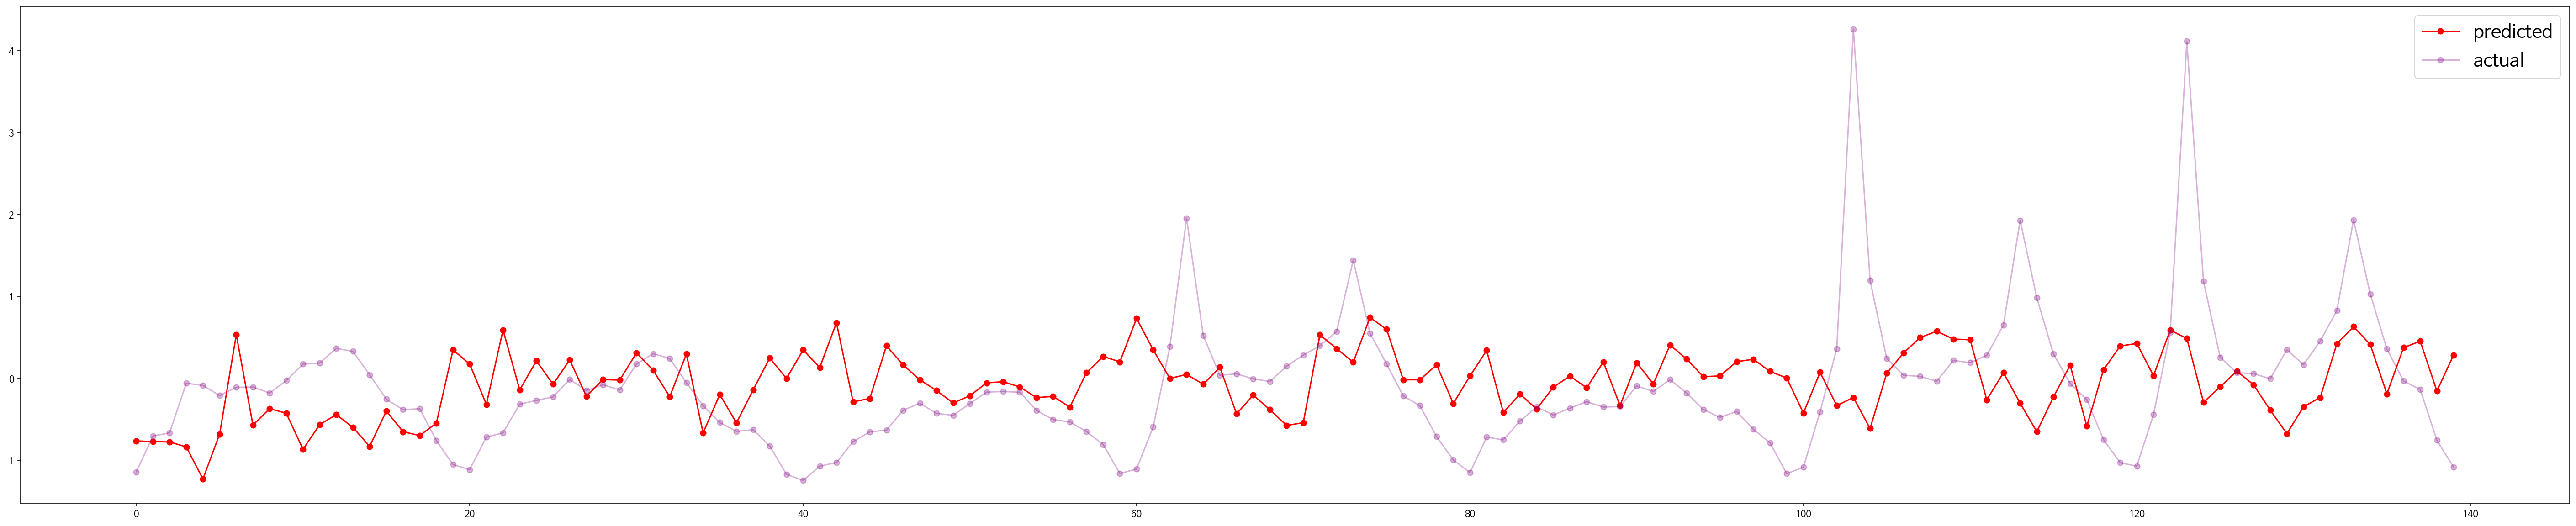

In [ ]:
y_2_axis = np.arange(len(y_test))

plt.figure(figsize=(50,10))
plt.plot(y_2_axis, y_predicted, '-o', color='red', label='predicted') #x_test 예측값 그래프로 표현
plt.plot(y_2_axis, y_test, '-o', color='purple', alpha=0.3, label='actual') #y_test 실제값 그래프로 표현 
plt.legend(fontsize=20)
plt.show()

## 실시간 예측 예시

In [ ]:
with open('/content/drive/My Drive/빅콘/data_timeseries.pickle', 'rb') as f:
    time_series = pickle.load(f)

In [ ]:
subway = time_series[time_series['역명_label']==0]

In [ ]:
train = np.array(subway['하차'][:1800])
train = (train-train.mean(axis=0))/train.std(axis=0)
X_train = np.array([[[train[i+j]] for j in range(140)] for i in range(len(train)-140)])
y_train = np.array([[train[i+140]] for i in range(len(train)-140)])
test = np.array(subway['하차'][1800:])
test = (test-test.mean(axis=0))/test.std(axis=0)
X_test = np.array([[[test[i+j]] for j in range(140)] for i in range(len(test)-140)])
y_test = np.array([[test[i+140]] for i in range(len(test)-140)])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1660, 140, 1), (1660, 1), (480, 140, 1), (480, 1))

In [ ]:
model = tf.keras.Sequential()
model.add(layers.LSTM(140, return_sequences=True))
model.add(layers.Dropout(0.2)) # 규제 (레이어간)
model.add(layers.LSTM(20, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(5))
model.add(layers.Dense(1))
model.compile(optimizer='adam',loss='mse')
model.fit(X_train, y_train, epochs=100, verbose=1)

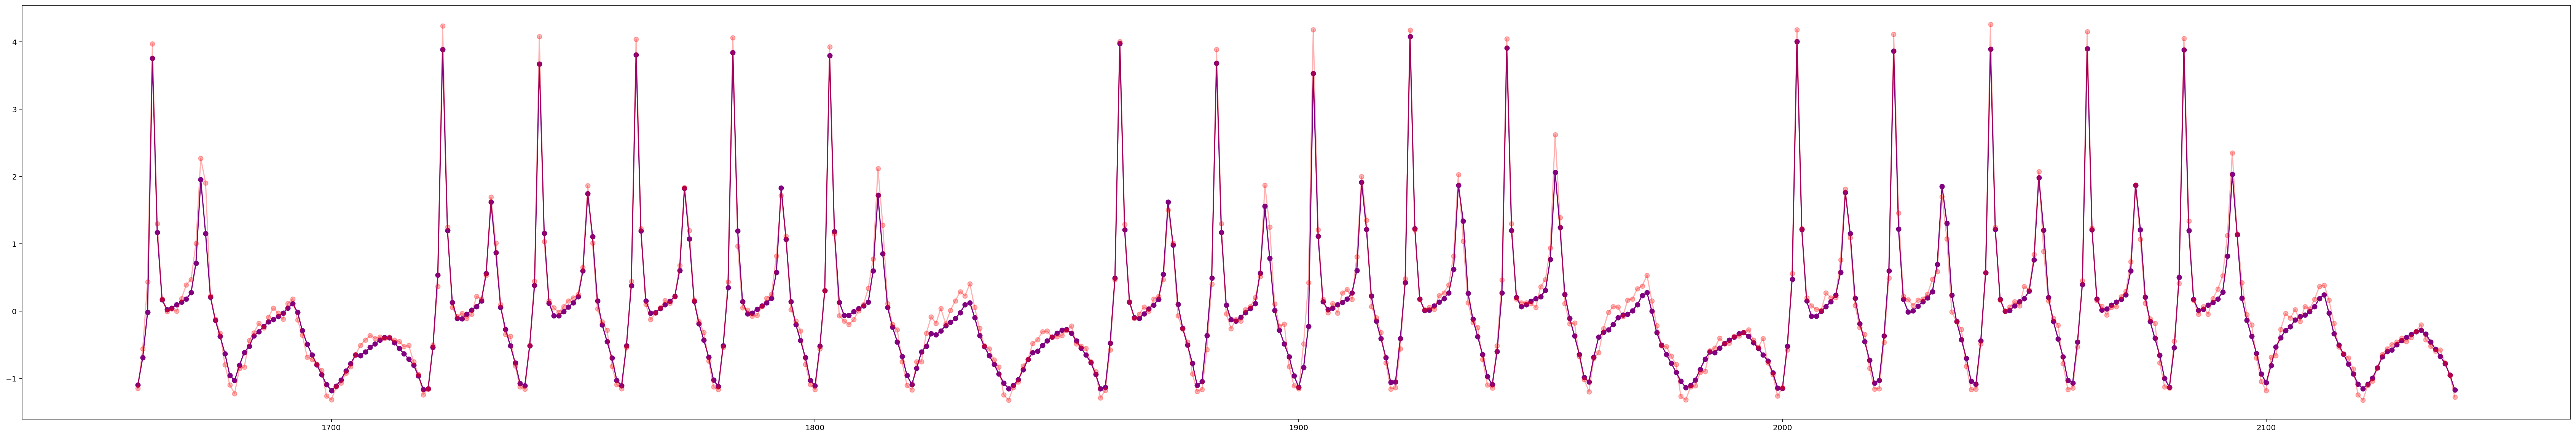

In [ ]:
y_hat = model.predict(X_test)
# y_axis = np.arange(0,len(y_train))
y2_axis = np.arange(len(y_train),len(y_train)+len(y_hat))

plt.figure(figsize=(60,10))
# plt.plot(y_axis, y_train.reshape(len(X_train),),'-o')
plt.plot(y2_axis, y_hat.reshape(len(X_test),),'-o',color='purple',label='predicted')
plt.plot(y2_axis, y_test.reshape(len(X_test),),'-o',color='red',alpha=0.3, label='actual')
plt.show()

In [ ]:
r2_score(y_test, y_hat)

0.9812283885311404

In [ ]:
num = len(set(time_series['역명_label']))

225

##1. 전체로 예측

In [ ]:
# 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10, 11, 12, 13 완료 14 진행 225
score_list = []
for i in tqdm(range(210,225)): #여기변경
    print('**************************{}번째**************************************'.format(i))
    subway = time_series[time_series['역명_label']==i]
    train = np.array(subway['하차'][:1800])
    train = (train-train.mean(axis=0))/train.std(axis=0)
    X_train = np.array([[[train[i+j]] for j in range(140)] for i in range(len(train)-140)])
    y_train = np.array([[train[i+140]] for i in range(len(train)-140)])
    test = np.array(subway['하차'][1800:])
    test = (test-test.mean(axis=0))/test.std(axis=0)
    X_test = np.array([[[test[i+j]] for j in range(140)] for i in range(len(test)-140)])
    y_test = np.array([[test[i+140]] for i in range(len(test)-140)])

    model = tf.keras.Sequential()
    model.add(layers.LSTM(140, return_sequences=True))
    model.add(layers.Dropout(0.2)) # 규제 (레이어간)
    model.add(layers.LSTM(20, return_sequences=True))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(5))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam',loss='mse')
    model.fit(X_train, y_train, epochs=100, verbose=1)
    y_hat = model.predict(X_test)
    score_list.append(r2_score(y_test, y_hat))
    print('*****************************************************************************')
    
with open('/content/drive/My Drive/빅콘/data14.pickle','wb') as f:   #여기 변경
    pickle.dump(score_list, f, pickle.HIGHEST_PROTOCOL)

**************************210번째**************************************
Epoch 1/100
52/52 [==============================] - 5s 89ms/step - loss: 0.8071
Epoch 2/100
52/52 [==============================] - 5s 90ms/step - loss: 0.4468
Epoch 3/100
52/52 [==============================] - 5s 89ms/step - loss: 0.3374
Epoch 4/100
52/52 [==============================] - 5s 89ms/step - loss: 0.2449
Epoch 5/100
52/52 [==============================] - 5s 90ms/step - loss: 0.2777
Epoch 6/100
52/52 [==============================] - 5s 90ms/step - loss: 0.1999
Epoch 7/100
52/52 [==============================] - 5s 90ms/step - loss: 0.1815
Epoch 8/100
52/52 [==============================] - 5s 90ms/step - loss: 0.1893
Epoch 9/100
52/52 [==============================] - 5s 89ms/step - loss: 0.1628
Epoch 10/100
52/52 [==============================] - 5s 90ms/step - loss: 0.1862
Epoch 11/100
52/52 [==============================] - 5s 89ms/step - loss: 0.1344
Epoch 12/100
52/52 [=================

In [ ]:
score = []
for i in range(15):
    with open('/content/drive/My Drive/빅콘/data{}.pickle'.format(i), 'rb') as f:
        score.extend(pickle.load(f))

In [ ]:
np.mean(score)

0.9462364289044218

In [ ]:
time_series['date_month'] = time_series['new_date'].dt.month
train = np.array(time_series[time_series['date_month']!= 5]['하차'])
test = np.array(time_series[time_series['date_month']== 5]['하차'])
train = (train-train.mean(axis=0))/train.std(axis=0)
X_train = np.array([[[train[i+j]] for j in range(140)] for i in range(len(train)-140)])
y_train = np.array([[train[i+140]] for i in range(len(train)-140)])
test = (test-test.mean(axis=0))/test.std(axis=0)
X_test = np.array([[[test[i+j]] for j in range(140)] for i in range(len(test)-140)])
y_test = np.array([[test[i+140]] for i in range(len(test)-140)])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((404860, 140, 1), (404860, 1), (139360, 140, 1), (139360, 1))

In [ ]:
model = tf.keras.Sequential()
model.add(layers.LSTM(140, return_sequences=True))
model.add(layers.Dropout(0.2)) # 규제 (레이어간)
model.add(layers.LSTM(20, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(5))
model.add(layers.Dense(1))
model.compile(optimizer='adam',loss='mse')

early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

model.fit(X_train, y_train, epochs=100, verbose=1,callbacks=[early_stop])
y_hat = model.predict(X_test)
r2_score(y_test, y_hat)

Epoch 1/100
12652/12652 [==============================] - 234s 18ms/step - loss: 0.2025
Epoch 2/100
12652/12652 [==============================] - 235s 19ms/step - loss: 0.0637
Epoch 3/100
12652/12652 [==============================] - 235s 19ms/step - loss: 0.0429
Epoch 4/100
12652/12652 [==============================] - 235s 19ms/step - loss: 0.0350
Epoch 5/100
12652/12652 [==============================] - 234s 19ms/step - loss: 0.0305
Epoch 6/100
12652/12652 [==============================] - 235s 19ms/step - loss: 0.0270
Epoch 7/100
12652/12652 [==============================] - 233s 18ms/step - loss: 0.0242
Epoch 8/100
12652/12652 [==============================] - 233s 18ms/step - loss: 0.0223
Epoch 9/100
12652/12652 [==============================] - 234s 19ms/step - loss: 0.0214
Epoch 10/100
12652/12652 [==============================] - 234s 19ms/step - loss: 0.0195
Epoch 11/100
12652/12652 [==============================] - 233s 18ms/step - loss: 0.0188
Epoch 12/100
12652/

0.9801900922954996

In [ ]:
model.save('/content/drive/My Drive/빅콘/lstm_model.h5')

##2. 역마다 예측

In [ ]:
num = len(set(time_series['역명_label']))
score_list = []
for i in tqdm(range(num)):
    print('**************************{}번째**************************************'.format(i))
    subway = time_series[time_series['역명_label']==i]
    train = np.array(subway['하차'][:1800])
    train = (train-train.mean(axis=0))/train.std(axis=0)
    X_train = np.array([[[train[i+j]] for j in range(140)] for i in range(len(train)-140)])
    y_train = np.array([[train[i+140]] for i in range(len(train)-140)])
    test = np.array(subway['하차'][1800:])
    test = (test-test.mean(axis=0))/test.std(axis=0)
    X_test = np.array([[[test[i+j]] for j in range(140)] for i in range(len(test)-140)])
    y_test = np.array([[test[i+140]] for i in range(len(test)-140)])

    model = tf.keras.Sequential()
    model.add(layers.LSTM(140, return_sequences=True))
    model.add(layers.Dropout(0.2)) # 규제 (레이어간)
    model.add(layers.LSTM(20, return_sequences=True))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(5))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam',loss='mse')
    model.fit(X_train, y_train, epochs=100, verbose=1)
    y_hat = model.predict(X_test)
    score_list.append(r2_score(y_test, y_hat))
    print('*****************************************************************************')